# Telco Customer Churn Prediction (Binary Classification)

![All Headers Explained](https://www.touchpoint.com/wp-content/uploads/2023/02/5.-Customer-churn-article.png)

image source: https://www.touchpoint.com/blog/what-is-customer-churn/

# Big Picture

Hello everyone! 

In this kernel, I will use a "[Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)" dataset to build a binary classification model. I am going to utilize multiple classification algorithms (Logistic Regression, SVC, Decision Tree, Ensembles, etc.) to determine the best model.


While I am using the dataset from Kaggle, it appears that the original data is sourced from the IBM Watson Analytics community.

The Telco Customer Churn data contains information about a fictional telco company that provided home phone and Internet services to __7,043__ customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. 

# Table of Contents <a id = 0></a>

- [Select a Performance Measure](#1)
- [Import Modules & Read the Dataset & Define Functions](#2)
- [Columns and Data Type](#3)
- [High-Level Overview](#4)
- [Create a Train Set and Test Set](#5)
- [EDA](#6)
 - [Target Variable](#6.1)
 - [Independent Variables](#6.2)
   - [Categorical Features](#6.2.1)
   - [Numerical Features](#6.2.2)
- [Build a Pipeline](#7)
- [Train, Compare, and Select a Model](#8)
 - [Logistic Regression](#8.1)
   - [Precision-Recall Curve](#8.1.1)
   - [Hyperparameter Tuning](#8.1.2)
   - [Evaluate a Model with the Test Set](#8.1.3)
   - [ROC and AUC](#8.1.4)
 - [Support Vector Machines](#8.2)
   - [Precision-Recall Curve](#8.2.1)
   - [Hyperparameter Tuning](#8.2.2)
   - [Evaluate a Model with the Test Set](#8.2.3)
   - [ROC and AUC](#8.2.4)
 - [Decision Tree](#8.3)
   - [Visualizing a Decision Tree](#8.3.1)
   - [Feature Importance](#8.3.2)
   - [Hyperparameter Tuning](#8.3.3)
   - [Precision-Recall Curve](#8.3.4)
   - [Evaluate a Model with the Test Set](#8.3.5)
   - [ROC and AUC](#8.3.6)
 - [Random Forest](#8.4)
   - [Hyperparameter Tuning](#8.4.1)
   - [Precision-Recall Curve](#8.4.2)
   - [Evaluate a Model with the Test Set](#8.4.3)
   - [ROC and AUC](#8.4.4)
   - [Feature Importance](#8.4.5)
 - [AdaBoost](#8.5)
   - [Hyperparameter Tuning](#8.5.1)
   - [Precision-Recall Curve](#8.5.2)
   - [Evaluate a Model with the Test Set](#8.5.3)
   - [ROC and AUC](#8.5.4)
   - [Feature Importance](#8.5.5)
 - [Gradient Boosting](#8.6)
   - [Hyperparameter Tuning](#8.6.1)
   - [Precision-Recall Curve](#8.6.2)
   - [Evaluate a Model with the Test Set](#8.6.3)
   - [ROC and AUC](#8.6.4)
   - [Feature Importance](#8.6.5)
 - [Voting](#8.7)
   - [Precision-Recall Curve](#8.7.1)
   - [Evaluate a Model with the Test Set](#8.7.2)
   - [ROC and AUC](#8.7.3)
- [Choose a Model](#9)
- [Conclusion](#10)<br>

# 1. Select a Performance Measure <a id = 1></a>
[Return to Table of Contents](#0)

First, we should determine whether __false positive__ or __false negative__ costs us more. Let's assume that we are planning to send a follow-up email to the possible churners, offering a 10% discount for the next month if they complete 3 mins survey. 
- If we falsely predict non-churners as churners (__false positive__), we are essentially offering a 10% discount to customers who are not likely to churn, potentially resulting in lower sales revenue, while the cost of sending an email is relatively low. 
 - Assuming that sending an email costs the company \\$5, and the average monthly charge customers pay is \\$50, __the cost of false positive__ will be __\\$10__ (\\$5 for sending an email + \\$5 from the discount).
- If we falsely predict churners as non-churners (__false negative__), we will miss an opportunity to keep customers from churning, leading to customer loss.
 - We have not explored the data yet, but the average monthly charge customers pay is approximately \\$65. If we only think about the cost for the next month, __the cost of false negative__ is estimated to be around __\\$65__ (resulting in a \\$780 loss in a year).
 
 
Clearly, false negatives will cost us more, so we should focus on minimizing false negatives. In such a case, we should prioritize ___recall___ score over ___precision___ score.

Ideally, we would want high scores for both precision and recall (and/or accuracy), but unfortunately, this is usually not the case. High recall score usually comes at the expense of the precision score, and vise versa.

With that being said, __I am hoping to accomplish a recall score of 0.8 at not too low precision score.__

# 2. Import Modules & Read the Dataset & Define Functions <a id = 2></a>
[Return to Table of Contents](#0)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, make_scorer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
def beautified_confusion_matrix(confusion_matrix, model_name):
    sns.heatmap(
        confusion_matrix,
        cmap = 'Blues',
        annot = True,
        fmt = 'g',
        square = True,
        xticklabels = ['No Churn', 'Churn'],
        yticklabels = ['No Churn', 'Churn']
    ).set(
        xlabel = 'Prediction',
        ylabel = 'Actual',
        title = f'{model_name} Confusino Matrix'
    )

In [4]:
def precision_recall_curve_using_proba(true_y, y_probs, model_name):
    precisions, recalls, thresholds = precision_recall_curve(true_y, y_probs)

    threshold_idx = np.argmin(np.abs(thresholds - 0.5))
    recall_threshold = 0.8
    recall_idx = np.argmax(recalls <= recall_threshold)

    plt.plot(thresholds, precisions[:-1], label='Precision', color = "blue", linestyle = '-')
    plt.plot(thresholds, recalls[:-1], label="Recall", color = "green", linestyle = '-')

    plt.axvline(x=0.5, color='grey', linestyle='--', label='Default Threshold: 0.5')
    plt.plot(thresholds[threshold_idx], precisions[threshold_idx], "bo")
    plt.plot(thresholds[threshold_idx], recalls[threshold_idx], "go")

    plt.axvline(x=thresholds[recall_idx], color='green', linestyle=':', label='Recall = 0.8')
    plt.plot(thresholds[recall_idx], precisions[recall_idx], "bo")
    plt.plot(thresholds[recall_idx], recalls[recall_idx], "go")

    plt.xlabel('Decision Threshold')
    plt.ylabel('Scores')
    plt.legend()
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.show()

In [5]:
def decision_threshold(true_y, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(true_y, y_probs)
    
    recall_threshold = 0.8
    recall_idx = np.argmax(recalls <= recall_threshold)

    return thresholds[recall_idx]

In [6]:
def precision_recall_curve_using_score(true_y, y_scores, model_name, min_xaxis = -5, max_xaxis = 5):
    
    precisions, recalls, thresholds = precision_recall_curve(true_y, y_scores)

    threshold = 0
    threshold_idx = (thresholds >= threshold).argmax()
    recall_threshold = 0.8
    recall_idx = np.argmax(recalls <= recall_threshold)

    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

    plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold = 0")
    plt.plot(thresholds[threshold_idx], precisions[threshold_idx], "bo")
    plt.plot(thresholds[threshold_idx], recalls[threshold_idx], "go")


    recall_idx = (np.abs(recalls - recall_threshold)).argmin()
    plt.vlines(thresholds[recall_idx], 0, 1.0, color = "green", linestyle = ":", label="recall = 0.8")
    plt.plot(thresholds[recall_idx], precisions[recall_idx], "bo")
    plt.plot(thresholds[recall_idx], recalls[recall_idx], "go")

    plt.axis([min_xaxis, max_xaxis, 0, 1])
    plt.xlabel("Threshold")
    plt.ylabel("Scores")
    plt.title(f'{model_name} - Precision/Recall vs Decision Threshold')
    plt.legend(loc="center right")

    plt.show();
    
    
    plt.plot(recalls, precisions, linewidth=2, label=f"{model_name} Precision/Recall curve")

    plt.plot([recalls[threshold_idx], recalls[threshold_idx]], [0., precisions[threshold_idx]], c = 'grey', linestyle = ":")
    plt.plot([0.0, recalls[threshold_idx]], [precisions[threshold_idx], precisions[threshold_idx]], c = 'grey', linestyle = ":")
    plt.plot([recalls[threshold_idx]], [precisions[threshold_idx]], "ko", label = 'Point at threshold = 0')

    plt.plot([recalls[recall_idx], recalls[recall_idx]], [0., precisions[recall_idx]], c = 'green', linestyle = ":")
    plt.plot([0.0, recalls[recall_idx]], [precisions[recall_idx], precisions[recall_idx]], c = 'green', linestyle = ":")
    plt.plot([recalls[recall_idx]], [precisions[recall_idx]], "go", label = 'Point at recall = 0.8')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.title(f'{model_name} - Precision vs Recall')
    plt.legend(loc="lower left")

    plt.show();

In [7]:
def score_threshold(true_y, y_scores):
    precisions, recalls, thresholds = precision_recall_curve(true_y, y_scores)
    
    recall_threshold = 0.8
    recall_idx = np.argmax(recalls <= recall_threshold)

    return thresholds[recall_idx]

# 3. Columns and Data Type <a id = 3></a>
[Return to Table of Contents](#0)

Below is the description of each column in this dataset:

__Customer Demographic Info:__
- customerID
- gender: Whether the customer is a male or a female
- SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)
- Partner: Whether the customer has a partner or not (Yes, No)
- Dependents: Whether the customer has dependents or not (Yes, No)

__Customer Account Info:__
- tenure: Number of months the customer has stayed with the company
- Contract: The contract term of the customer (Month-to-month, One year, Two year)
- PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)
- PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges: The amount charged to the customer monthly
- TotalCharges: The total amount charged to the customer

__Services:__
- PhoneService: Whether the customer has a phone service or not (Yes, No)
- MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)
- OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)
- TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)
- StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)
- StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)

__Target:__
- Churn: Whether the customer churned or not (Yes or No)

# 4. High-Level Overview <a id = 4></a>
[Return to Table of Contents](#0)

In [8]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

It looks like data type of "TotalCharges" is an object, not a float. It turns out that the column has spaces (' ') instead of blank values when there is no "TotalCharges." Let's take a closer loot at them.

In [11]:
df[df['TotalCharges'] == ' ']

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ...   
753           Yes                No              No  No internet service  ...   
936           Yes                No             DSL                  Yes  ...   
1082          Yes               Yes              No  No internet service  ...   
1340           No  No phone service             DSL                  Yes  ...   
3331          Yes                No              No  No internet service  ...   
3826          Yes               Yes              No  No internet service  ...   
4380          Yes                No              No  No internet service  ...   
5218          Yes                No              No  No internet service  ...   
6670          Yes               Yes             DSL                   No  ...   
6754          Yes               Yes             DSL                  Yes  ...   

         DeviceProtection          TechSupport          StreamingTV  \
488                   Yes                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                   No                  Yes   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                   No                  Yes                   No   

          StreamingMovies  Contract PaperlessBilling  \
488                    No  Two year              Yes   
753   No internet service  Two year               No   
936                   Yes  Two year               No   
1082  No internet service  Two year               No   
1340                   No  Two year               No   
3331  No internet service  Two year               No   
3826  No internet service  Two year               No   
4380  No internet service  Two year               No   
5218  No internet service  One year              Yes   
6670                   No  Two year               No   
6754                   No  Two year              Yes   

                  PaymentMethod MonthlyCharges  TotalCharges Churn  
488   Bank transfer (automatic)          52.55                  No  
753                Mailed check          20.25                  No  
936                Mailed check          80.85                  No  
1082               Mailed check          25.75                  No  
1340    Credit card (automatic)          56.05                  No  
3331               Mailed check          19.85                  No  
3826               Mailed check          25.35                  No  
4380               Mailed check          20.00                  No  
5218               Mailed check          19.7

It seems that these customers have just started using Telco's service and have not been charged anything yet (i.e., still within a month since the 1st date). Let's replace the empty spaces (' ') with 0.

In [12]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0).astype('float')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [14]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2279.734304
std         0.368612    24.559481       30.090047   2266.794470
min         0.000000     0.000000       18.250000      0.000000
25%         0.000000     9.000000       35.500000    398.550000
50%         0.000000    29.000000       70.350000   1394.550000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000

Okay, the "TotalCharges" column is now updated with the correct data type. 

We can also see that some columns are already binary flags (1 or 0) while other columns are still categorical (Yes or No). Later, we are going to create dummy variables, but before doint that, if we look at "PhoneService" and "MultipleLines", "MultiLines" is always "No internet service" when "PhoneService" is "No" and is either "Yes" or "No" when "PhoneService" is "Yes". I believe we can combine them into one column. It is usually better to keep the data simple. We can also see the similar case for "InternetService" and columns for additional internet services, such as "OnlineSecurity", "OnlineBackup", etc. Let's transform them before one-hot encoding. 

In [15]:
# Phone Service
choices_phone = [
    'Multiple-Lines',
    'Single-Line'
]

conditions_phone = [
    (df['PhoneService'] == 'Yes') & (df['MultipleLines'] == 'Yes'),
    (df['PhoneService'] == 'Yes') & (df['MultipleLines'] == 'No')
]

df['PhoneService'] = np.select(conditions_phone, choices_phone, default = 'No Phone Service')

# Internet Service
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

choices_internet = [
    'DSL-Yes',
    'FiberOptic-Yes',
    'DSL-No',
    'FiberOptic-No'
]

for service in internet_services:
    conditions_internet = [
        (df['InternetService'] == 'DSL') & (df[service] == 'Yes'),
        (df['InternetService'] == 'Fiber optic') & (df[service] == 'Yes'),
        (df['InternetService'] == 'DSL') & (df[service] == 'No'),
        (df['InternetService'] == 'Fiber optic') & (df[service] == 'No')
    ]
    df[service] = np.select(conditions_internet, choices_internet, default='No Internet Service')

# Target Variable
df['Churn'] = np.where(df['Churn'] == "Yes", 1, 0)

In [16]:
df.drop(['MultipleLines', 'InternetService', 'customerID'], axis = 1, inplace = True)

# 5. Create a Train Set and Test Set <a id = 5></a>
[Return to Table of Contents](#0)

Before exploring the data, let's split the data into a training and test set to prevent our model from becoming too optimistic. I usually prefer to split data into a training, cross-validation, and test set, but as this dataset is not learge, I will only create a training and test set. Moving forward, I will use the training set to explore the data.

In [17]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

# 6. EDA <a id = 6></a>
[Return to Table of Contents](#0)

Let's explore the data. I will create a copy of the traning set so that I can revert to it later.

In [18]:
train_eda = train.copy()

## 6.1. Target Variable <a id = 6.1></a>
[Return to Table of Contents](#0)

Let's first take a look at the target variable.

In [19]:
train_eda['Churn'].value_counts()

Churn
0    4138
1    1496
Name: count, dtype: int64

Note from the table above:
- About 36% of the training set is the positive class. It's not perfectly balanced (50%/50%), but I do not think this is too imbalanced either, so I wil not perform any oversampling/undersampling. 

Now, let's look at the independent variables.

## 6.2. Independent Variables <a id = 6.2></a>
### 6.2.1. Categorical Features <a id = 6.2.1></a>
[Return to Table of Contents](#0)

gender
Male      51.2%
Female    48.8%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

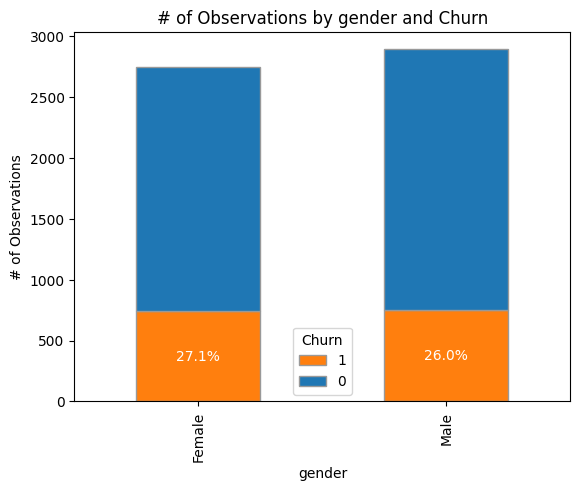


Partner
No     51.5%
Yes    48.5%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

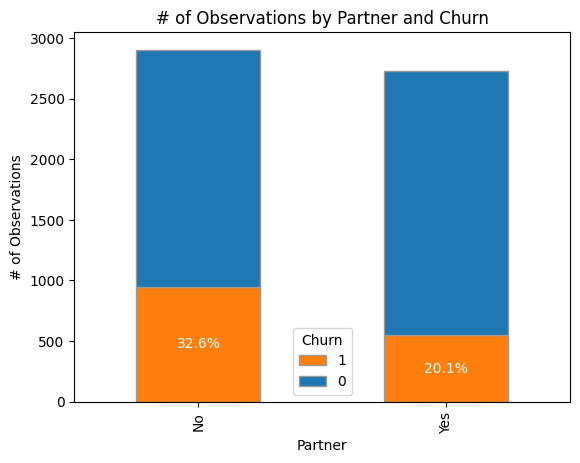


Dependents
No     70.1%
Yes    29.9%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

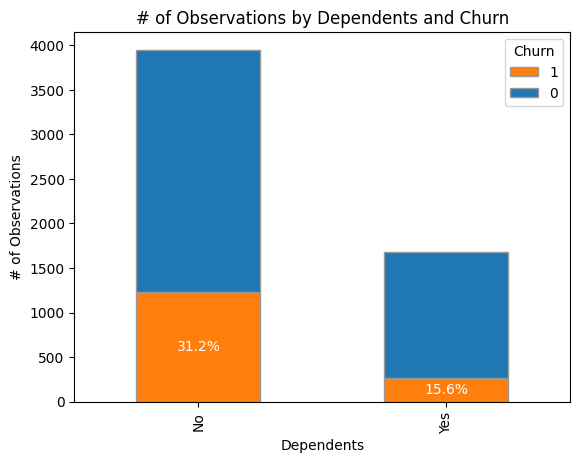


PhoneService
Single-Line         47.7%
Multiple-Lines      42.5%
No Phone Service     9.8%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

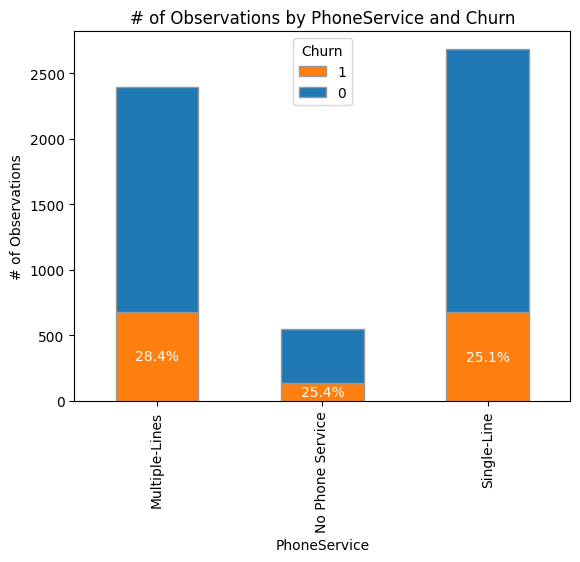


OnlineSecurity
FiberOptic-No          32.1%
No Internet Service    21.5%
DSL-No                 17.8%
DSL-Yes                16.6%
FiberOptic-Yes         11.9%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

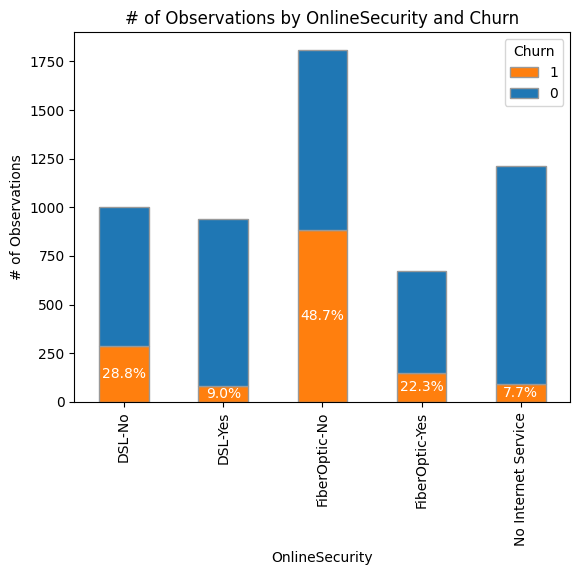


OnlineBackup
FiberOptic-No          24.7%
No Internet Service    21.5%
FiberOptic-Yes         19.3%
DSL-No                 18.7%
DSL-Yes                15.7%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

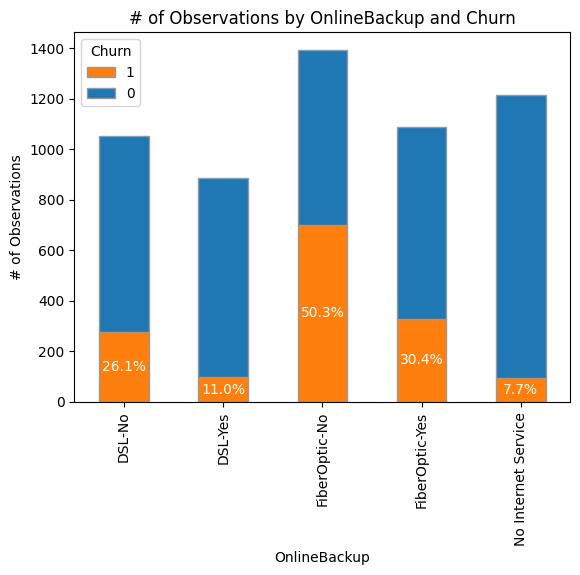


DeviceProtection
FiberOptic-No          24.8%
No Internet Service    21.5%
DSL-No                 19.4%
FiberOptic-Yes         19.2%
DSL-Yes                15.1%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

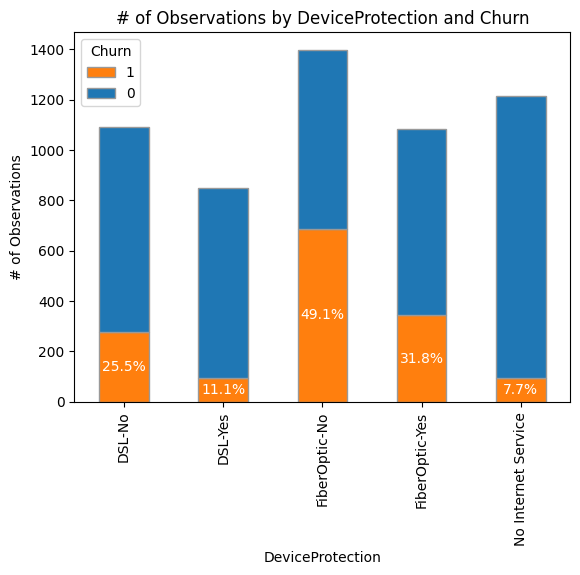


TechSupport
FiberOptic-No          31.8%
No Internet Service    21.5%
DSL-No                 17.8%
DSL-Yes                16.6%
FiberOptic-Yes         12.3%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

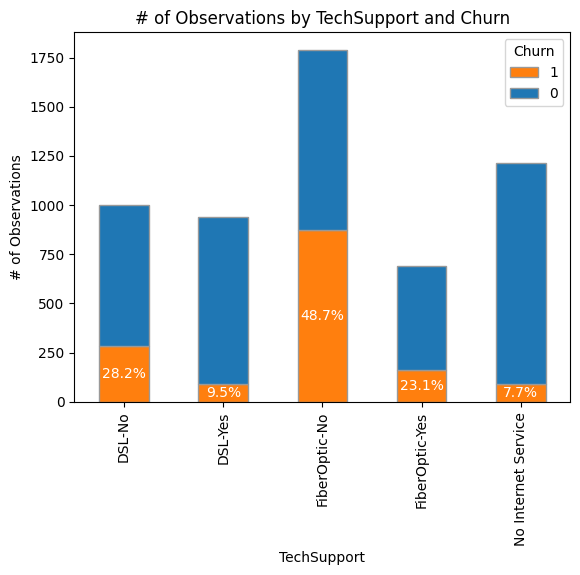


StreamingTV
FiberOptic-Yes         24.9%
No Internet Service    21.5%
DSL-No                 20.6%
FiberOptic-No          19.2%
DSL-Yes                13.8%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

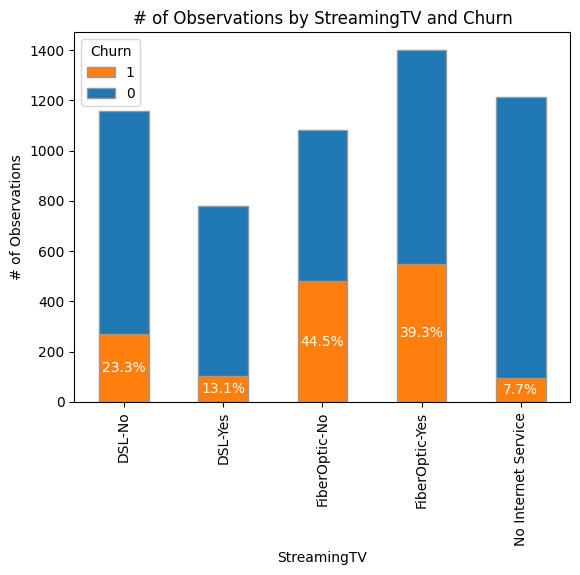


StreamingMovies
FiberOptic-Yes         24.8%
No Internet Service    21.5%
DSL-No                 20.3%
FiberOptic-No          19.2%
DSL-Yes                14.1%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

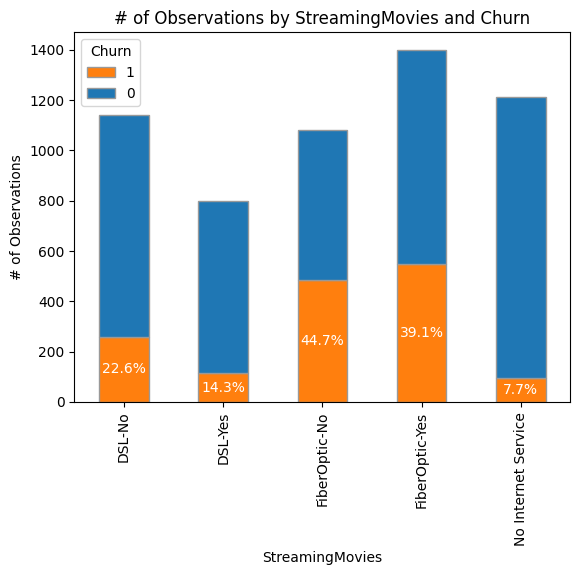


Contract
Month-to-month    54.7%
Two year          23.8%
One year          21.5%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

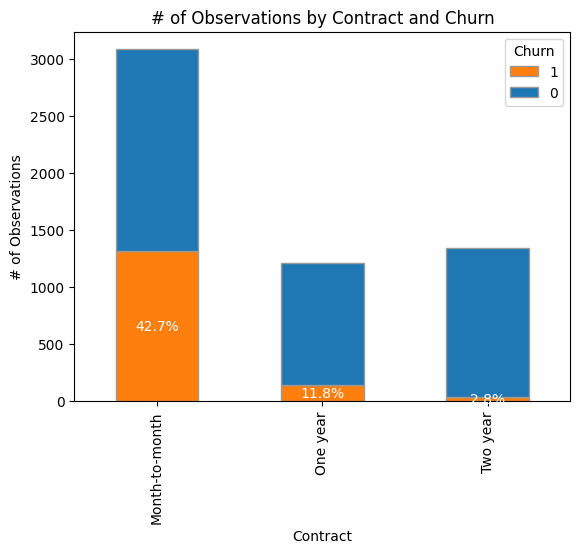


PaperlessBilling
Yes    59.0%
No     41.0%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

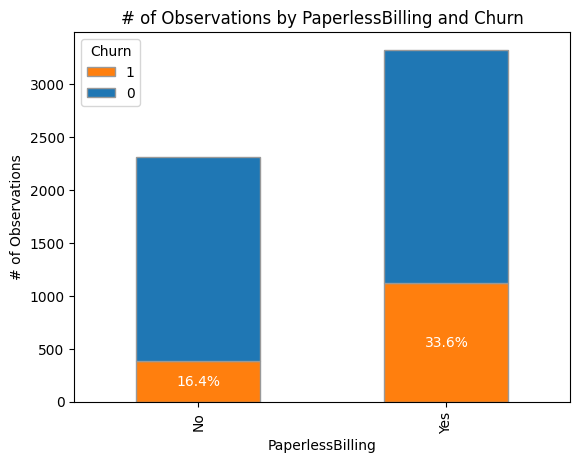


PaymentMethod
Electronic check             33.5%
Mailed check                 22.8%
Bank transfer (automatic)    22.0%
Credit card (automatic)      21.8%
Name: proportion, dtype: object



<Figure size 1000x600 with 0 Axes>

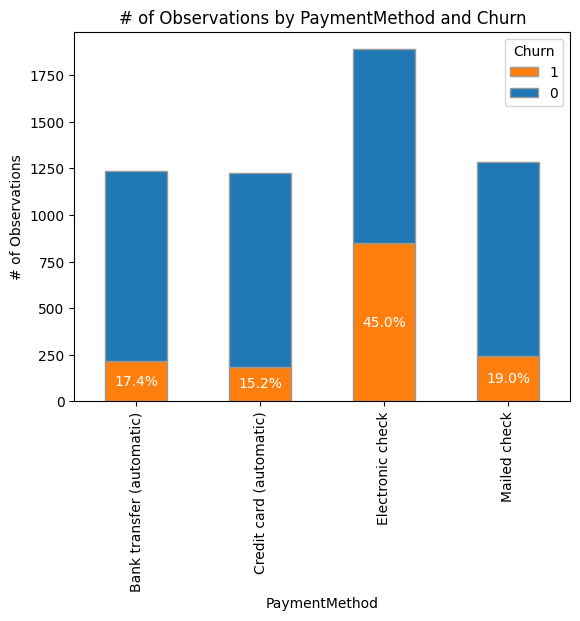

In [20]:
cat_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in cat_features:
    print(train_eda[col].value_counts(ascending=False, normalize=True).map(lambda x: '{:.1%}'.format(x)))
    print()
    
    churn_counts = train_eda.groupby([col, 'Churn']).size().unstack().loc[:, [1,0]]
    churn_rates = churn_counts[1] / churn_counts.sum(axis=1)
    
    plt.figure(figsize=(10, 6))
    ax = churn_counts.plot(kind='bar', stacked=True, color=['#ff7f0e','#1f77b4'], edgecolor=".6", linewidth=1)

    for p, rate in zip(ax.patches, churn_rates):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()

        # Show label only for Churn = 1
        if rate > 0:
            ax.annotate(f'{rate:.1%}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, color='white')

    plt.xlabel(col)
    plt.ylabel('# of Observations')
    plt.title(f'# of Observations by {col} and Churn')
    plt.show()
    print()

Notes from the charts above:
- Customers who do NOT have a parter/dependents tend to have a higher chance of churning.
- Custoemrs who have Fiber Optic internet service but have no additional online services (security, backup, etc.) tend to have a higher chance of churning than other types of customers.
- Customers with a month-to-month contract tend to have a higher chance of churning than those with a one-year/two-year contract. 
- Customers with paperless billing tend to have a higher chance of churning than those with paper billing. 
- Customers with electronic check payment method tend to have a higher chance of churning than those with other payment methods.

We can use seaborn's pairplot for numerical features.

### 6.2.2. Numerical Features <a id = 6.2.2></a>
[Return to Table of Contents](#0)

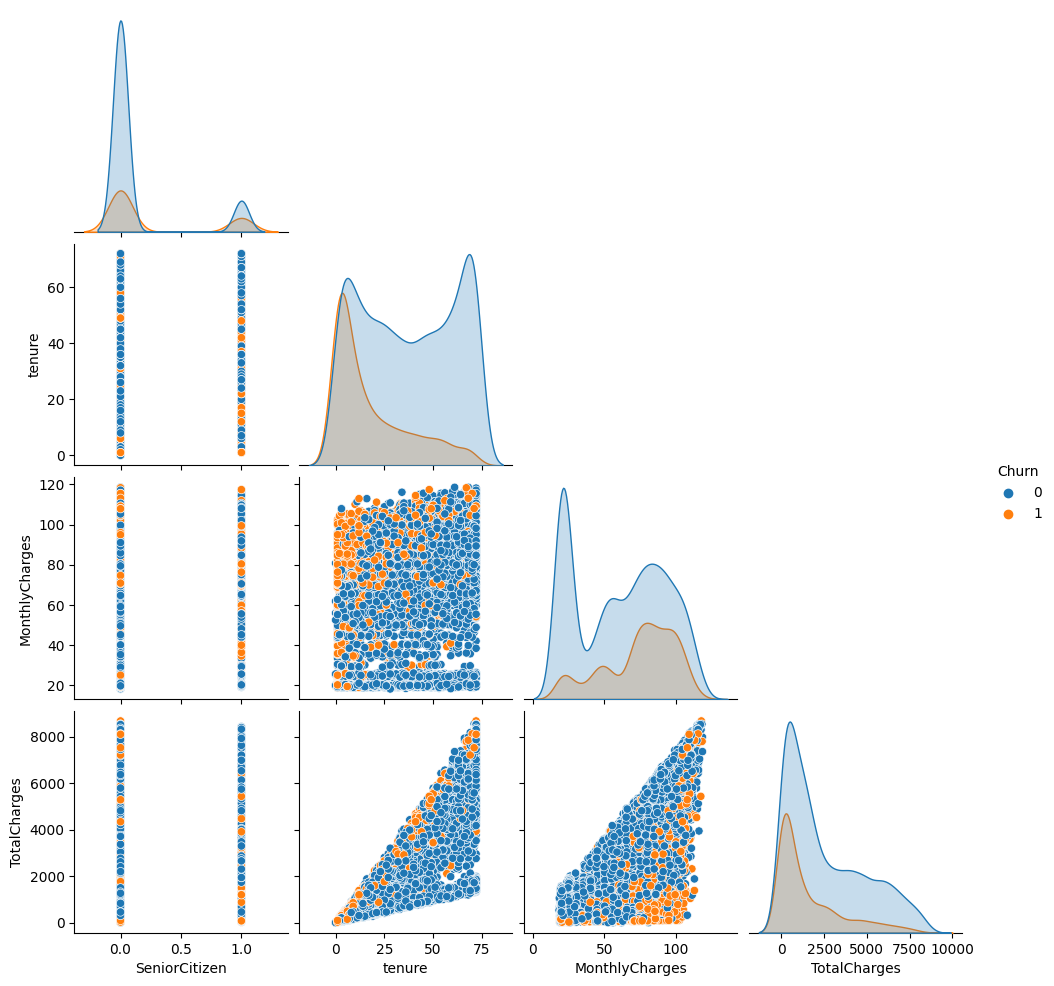

In [21]:
warnings.filterwarnings("ignore")

sns.pairplot(train_eda, corner = True, hue = 'Churn');

Note from the chart above:
- Tenure would be a good predictor: the longer customer has been using the service, the less likely they are to churn.

# 7. Build a Pipeline <a id = 7></a>
[Return to Table of Contents](#0)

Now, we are almost ready for data modeling. But before that, let's create a pipeline for the preprocessing steps.

In [22]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

preprocessing = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), num_features),
        ('categorical', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'), cat_features)
    ])

pipeline = Pipeline(steps=[('preprocessing', preprocessing)])

In [23]:
X_train = train.drop('Churn', axis = 1)
y_train = train['Churn']
X_test = test.drop('Churn', axis = 1)
y_test = test['Churn']

In [24]:
X_train = pipeline.fit_transform(X_train)

numeric_feature_names = num_features
categorical_feature_names = pipeline.named_steps['preprocessing'].named_transformers_['categorical'] \
    .get_feature_names_out(cat_features)

all_feature_names = numeric_feature_names + categorical_feature_names.tolist()

X_train = pd.DataFrame(X_train, columns=all_feature_names)

In [25]:
X_test = pipeline.transform(X_test)

numeric_feature_names = num_features
categorical_feature_names = pipeline.named_steps['preprocessing'].named_transformers_['categorical'] \
    .get_feature_names_out(cat_features)

all_feature_names = numeric_feature_names + categorical_feature_names.tolist()

X_test = pd.DataFrame(X_test, columns=all_feature_names)

# 8. Train, Compare, and Select a Model <a id = 8></a>
[Return to Table of Contents](#0)

Logistic Regression is always a good algoritgm to start with when you work on binary classification tasks.

## 8.1. Logistic Regression <a id = 8.1></a>
[Return to Table of Contents](#0)

_Logistic Regression_ is commonly used to estimate the probablity that an instance belongs to a particular class. If the estimated probability is greater than a given threshold (typically 0.5 by default), then the model predicts that the instance belongs to that class, and otherwise it predicts that it does not. You can change the threshold to tune the precision/recall score. 

Accuracy: 0.8
Precision: 0.651
Recall: 0.533
F1: 0.587


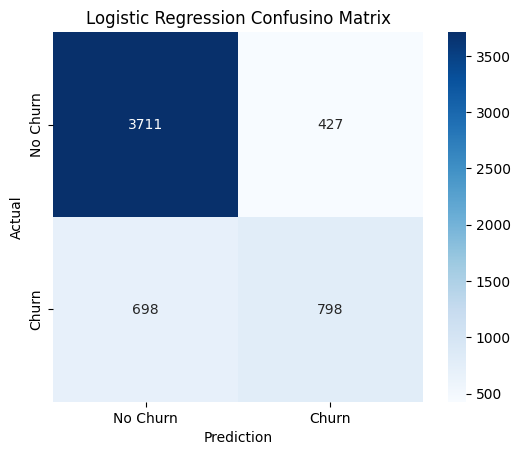

In [26]:
lr = LogisticRegression()

y_pred = cross_val_predict(lr, X_train, y_train, cv=5)

lr_confusion_matrix = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(lr_confusion_matrix, 'Logistic Regression')

### 8.1.1. Precision-Recall Curve <a id = 8.1.1></a>
[Return to Table of Contents](#0)

As mentioned earlier, increasing precision usually reduces recall, and increasing recall usually reduces precision. You can also change the threshold to tune these scores. But how do we decide which threshold to use? We can use ___precision-recall curve()___ from scikit learn to compute precision and recall for all possible thresholds. We can use either "predict_proba" or "decision_function" to accomplish this. To better understand what is happening under the hood, let's first look at how Logistic Regression is computed.

1. Linear Combination:
 - Logistic Regression starts with a linear combination of the input features. For a dataset with n features, the linear combination (__decision function__) for a single example is calculated as: 
 $ z = b_0 + b_1 \cdot x_1 + b_2 \cdot x_2 + \ldots + b_n \cdot x_n $


2. Sigmoid Function:
 - The linear combination z is then passed through the sigmoid function (σ), which transforms the result into a probability between 0 and 1:  
 $ \sigma(z) = \frac{1}{1 + e^{-z}} $ 
 - The sigmoid function "squashes" the values into the range (0, 1) and is crucial for logistic regression to provide probability estimates.
 

3. Decision Rule:
 - A decision rule is applied to the probability output to make a binary prediction. A threshold of 0.5 is typically used: if σ(z)≥0.5, predict class 1; otherwise, predict class 0.


4. Training:
 - During training, the model learns the optimal values for the coefficients _b₀, b₁, ..., bₙ_ by minimizing a cost function. This is typically done using techniques like maximum likelihood estimation or gradient descent.
 
 
In summary, "decision_function" provides the raw scores of the linear equation before applying the sigmoid function and "predict_proba" gives us probabilities after the application of the sigmoid function. Let's plot precision-recall curve using them.

### Using Predict Proba

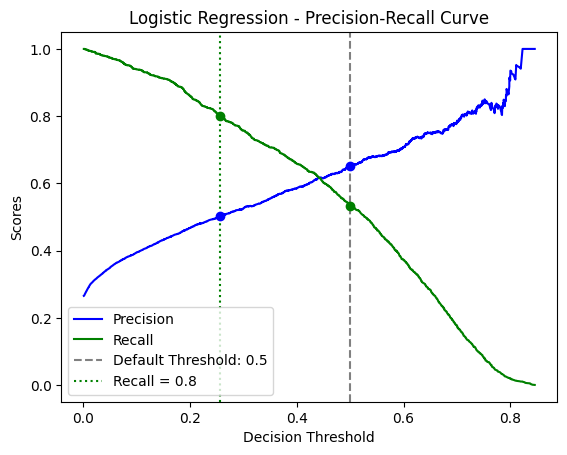

In [27]:
y_probs = cross_val_predict(LogisticRegression(), X_train, y_train, cv=5, method='predict_proba')[:, 1]

precision_recall_curve_using_proba(y_train, y_probs, "Logistic Regression")

In [28]:
lr_decision_threshold = decision_threshold(y_train, y_probs)
lr_decision_threshold

0.2569387933352756

The output indicates that we should be able to acheive 0.8 recall score by setting the threshold to 0.26. This means that the model will predict an instance as positive if its probability of the positive class is greater than or equal to that threshold. Let's try.

Accuracy: 0.736
Precision: 0.502
Recall: 0.799
F1: 0.617


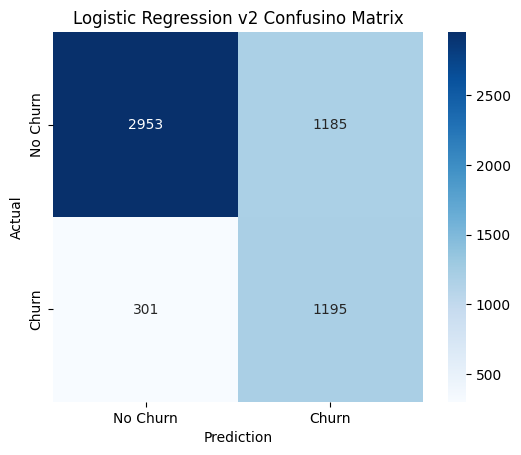

In [29]:
lr = LogisticRegression()

y_probs = cross_val_predict(lr, X_train, y_train, cv=3, method='predict_proba')[:, 1]
y_pred = (y_probs >= lr_decision_threshold)

lr_confusion_matrix_v2 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(lr_confusion_matrix_v2, 'Logistic Regression v2')

Notes from the data above:
- Recall went up by 0.266 while accuracy and precision went down.
- Confusion matrix shows that this model produced much less false negatives than the previous model (698 -> 301) at the expense of false positives.  (427 -> 1185)

### Using Decision Function

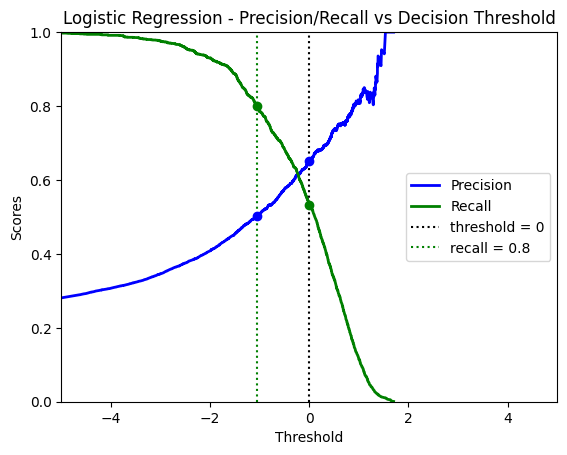

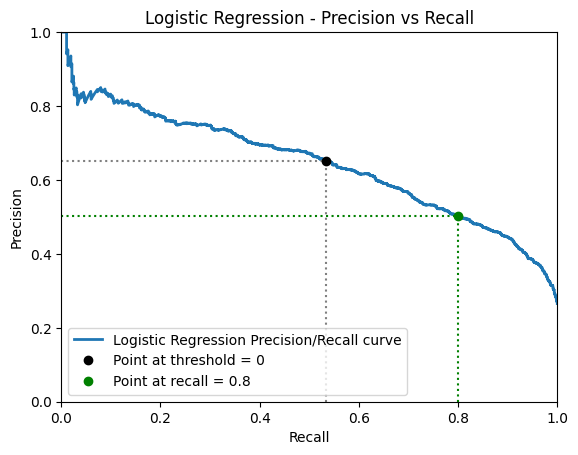

In [30]:
y_scores = cross_val_predict(LogisticRegression(), X_train, y_train, cv = 5, method = 'decision_function')

precision_recall_curve_using_score(y_train, y_scores, 'Logistic Regression')

In [31]:
lr_threshold_score = score_threshold(y_train, y_scores)
lr_threshold_score

-1.0619405207676083

The charts above are essentially showing the same information in different ways. The first line graph plots precision and recall as functions of the threshold value. In the second line graph, it plots precision directly against recall.

We can see that 0.8 recall score can be achieved by setting the threshold at around -1.6.

Accuracy: 0.736
Precision: 0.502
Recall: 0.799
F1: 0.617


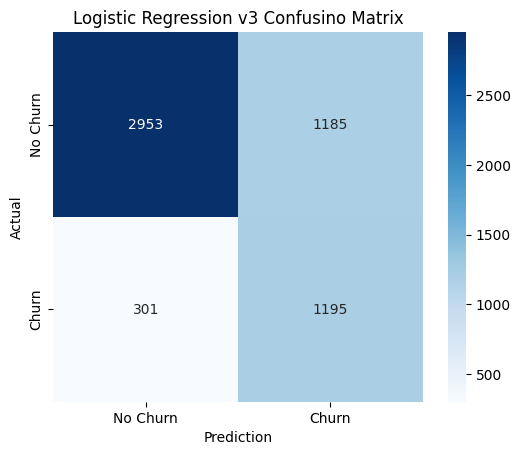

In [32]:
lr = LogisticRegression()
y_scores = cross_val_predict(lr, X_train, y_train, cv=3, method='decision_function')
y_pred = (y_scores >= lr_threshold_score)

lr_confusion_matrix_v3 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(lr_confusion_matrix_v3, 'Logistic Regression v3')

We got the exactly same result from the previous one that used the "predict_proba" method.

### 8.1.2. Hyperparameter Tuning <a id = 8.1.2></a>
[Return to Table of Contents](#0)

For linear regression, we can tune regularization strength, penalty type, solver, etc.

In [33]:
params = {
    'C': np.linspace(.1, 2, 20),
    'penalty': ['l1', 'l2']
}

gs = GridSearchCV(LogisticRegression(solver = 'saga'), params, cv = 5)

gs.fit(X_train, y_train)

gs.best_params_

{'C': 0.2, 'penalty': 'l1'}

Accuracy: 0.738
Precision: 0.504
Recall: 0.795
F1: 0.617


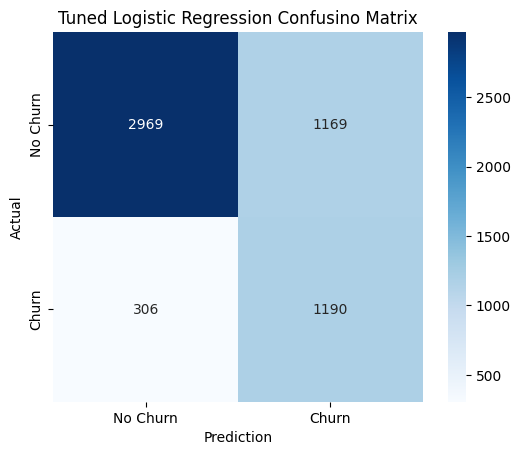

In [34]:
lr = LogisticRegression(solver = 'saga', **gs.best_params_)
y_probs = cross_val_predict(lr, X_train, y_train, cv=3, method='predict_proba')
y_probs = y_probs[:, 1]
y_pred = (y_probs >= lr_decision_threshold)

tuned_lr_confusion_matrix = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(tuned_lr_confusion_matrix, 'Tuned Logistic Regression')

Notes from the data above:
- With regularization, false negatives increased by 5 while false positives decreased by 16. 
- The recall score slightly went down by 0.04 while accuracy and precision slightly went up. This time, hyperparameter tuning did not significantly improve the score, so I will stick with the previous one with no hyperparameter tuning. Let's try the model with the test data.

### 8.1.3. Evaluate a Model with the Test Set <a id = 8.1.3></a>
[Return to Table of Contents](#0)


Accuracy: 0.746
Precision: 0.512
Recall: 0.836
F1: 0.635


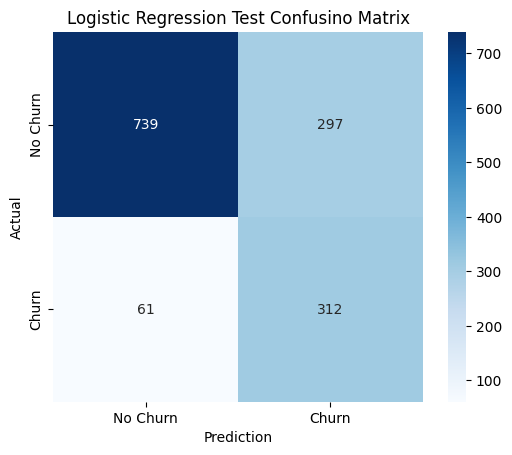

In [35]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
y_probs = lr.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= lr_decision_threshold)

lr_test_confusion_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)}')
print(f'Precision: {precision_score(y_test, y_pred).round(3)}')
print(f'Recall: {recall_score(y_test, y_pred).round(3)}')
print(f'F1: {f1_score(y_test, y_pred).round(3)}')
beautified_confusion_matrix(lr_test_confusion_matrix, 'Logistic Regression Test')

### 8.1.4. ROC and AUC <a id = 8.1.4></a>
[Return to Table of Contents](#0)

The ROC curve is another common tool used with binary classifiers. It is similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the _true positive rate_ (another name for recall) against the _false positive rate_ (FPR). The FPR is the ratio of negative instances that are incorrectly classified as negative. It is equal to 1 - the _true negative rate_ (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called _specificity_. Hence, the ROC curve plots _sensitvity_ (recall) versus 1 - _specificity_.

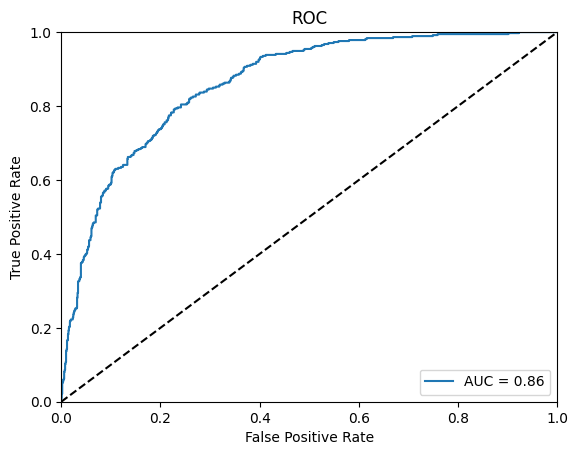

In [36]:
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_probs)
lr_roc_auc = auc(lr_fpr, lr_tpr)

plt.title('ROC')
plt.plot(lr_fpr, lr_tpr, label = 'AUC = %0.2f' % lr_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'k--', label = 'Random Guess')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (towards the top-left corner). We can compare classifiers with ROC by measuring the _area under the curve_ (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

If the ROC curve is very similar to precision/recall (PR) curve, how to decide which one to use? As a rule of thumb, we should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. 

We care more about the false positives in this task, so we should use the PR curve. In fact, looking at the ROC curve, you may think that the classifier is pretty good, but the PR curve makes it clear thatthe classifier has room for improvement: the curve could really be closer to the top-right corner. But we are still going to use the ROC to compare AUC for each model as the model with AUC closer to 1 usually performs better. 

## 8.2. Support Vector Machines <a id = 8.2></a>
[Return to Table of Contents](#0)

The main idea behind _SVM_ is to find a hyperplane that best separates the data into different classes. The "support vectors" are the data points that lie closest to the decision boundary (hyperplane), and the algorithm aims to maximize the margin between these support vectors while correctly classifying the data.

Support Vector Classification is particularly effective in handling high-dimensional spaces and is robust even in cases where the data is not linearly separable. Additionally, SVMs can handle both linear and non-linear classification problems by using different types of kernels.

Accuracy: 0.798
Precision: 0.671
Recall: 0.471
F1: 0.554
Confusion Matrix:


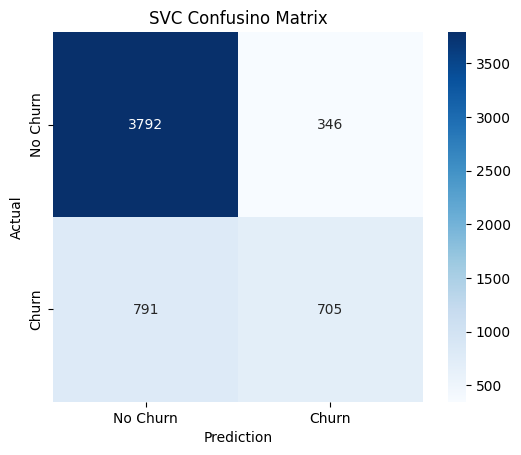

In [37]:
svc = SVC()

y_pred = cross_val_predict(svc, X_train, y_train, cv=5)

svc_confusion_matrix = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
print('Confusion Matrix:')
beautified_confusion_matrix(svc_confusion_matrix, "SVC")

### 8.2.1. Precision-Recall Curve <a id = 8.2.1></a>
[Return to Table of Contents](#0)

### Using Predict Proba

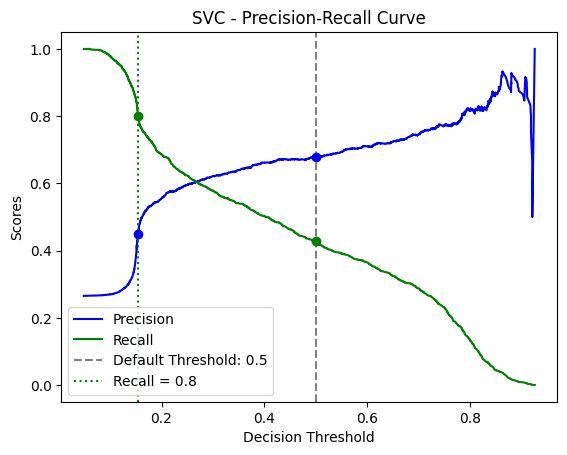

In [38]:
y_probs = cross_val_predict(SVC(probability = True), X_train, y_train, cv=5, method='predict_proba')[:, 1]

precision_recall_curve_using_proba(y_train, y_probs, "SVC")

In [39]:
svc_decision_threshold = decision_threshold(y_train, y_probs)
svc_decision_threshold

0.15437213716479958

Accuracy: 0.681
Precision: 0.445
Recall: 0.805
F1: 0.573


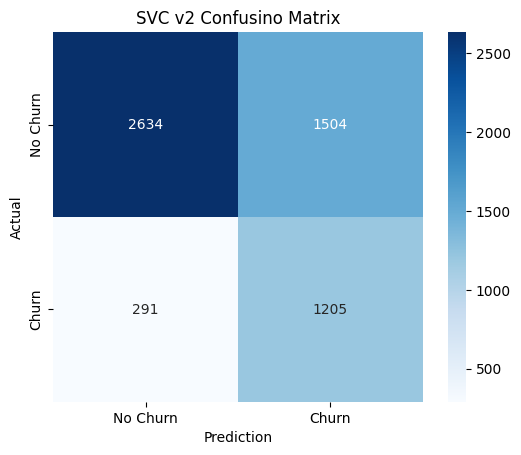

In [40]:
svc = SVC(probability = True)
y_probs = cross_val_predict(svc, X_train, y_train, cv=5, method='predict_proba')[:, 1]
y_pred = (y_probs >= svc_decision_threshold)

svc_confusion_matrix_v2 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(svc_confusion_matrix_v2, "SVC v2")

### Using Decision Function

The decision function in SVC is based on the concept of a signed distance. For a given input sample, the decision function calculates the signed distance of the sample to the hyperplane. The sign of this distance determines on which side of the hyperplane the sample lies.

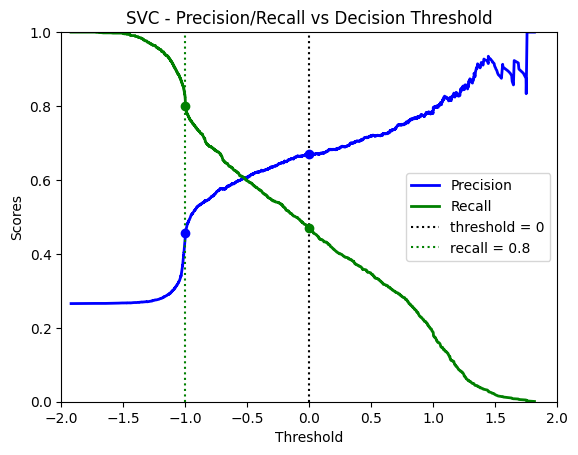

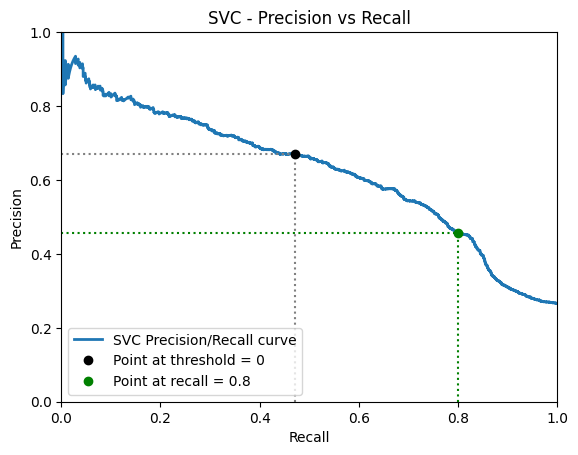

In [41]:
y_scores = cross_val_predict(svc, X_train, y_train, cv = 5, method = 'decision_function')

precision_recall_curve_using_score(y_train, y_scores, "SVC", -2, 2)

In [42]:
svc_threshold_score = score_threshold(y_train, y_scores)
svc_threshold_score

-0.9982804354513086

Accuracy: 0.693
Precision: 0.456
Recall: 0.799
F1: 0.58


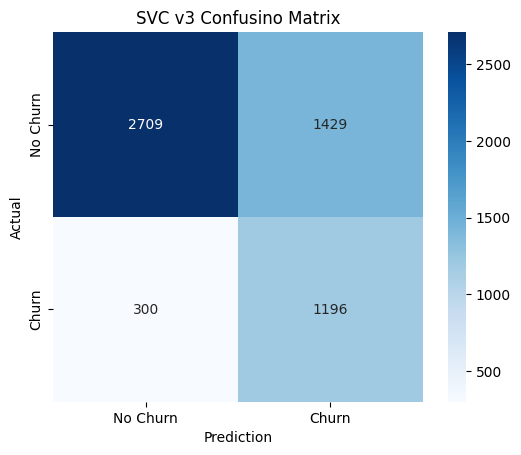

In [43]:
svc = SVC(probability = True)
y_scores = cross_val_predict(svc, X_train, y_train, cv=5, method='decision_function')
y_pred = (y_scores >= svc_threshold_score)

svc_confusion_matrix_v3 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(svc_confusion_matrix_v3, "SVC v3")

For SVC, usuing the decision_function method performed very slightly better than using the predict_proba method. 

### 8.2.2. Hyperparameter Tuning <a id = 8.2.2></a>
[Return to Table of Contents](#0)

For svc, we can tune regularization strength, kernel type, gamma, etc.

In [44]:
params = {
    'C': np.linspace(.1, 2, 20),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
#     'degree': [2, 3, 4],  # Only for poly kernel
#     'gamma': ['scale', 'auto', 0.1, 1, 10],  # For rbf, poly, sigmoid kernels
#     'coef0': [0.0, 0.1, 1.0],  # Only for poly and sigmoid kernels
}

rs = RandomizedSearchCV(SVC(probability = True), params, n_iter = 50, n_jobs = -1, cv=5)
rs.fit(X_train, y_train)

rs.best_params_

{'kernel': 'rbf', 'C': 1.4}

In [45]:
params = {
    'C': np.arange(1, 2.1, 0.1),
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

gs = GridSearchCV(SVC(probability = True), params, n_jobs = -1, cv=5)
gs.fit(X_train, y_train)

svc_best_params = gs.best_params_
svc_best_params

{'C': 1.4000000000000004, 'gamma': 'scale', 'kernel': 'rbf'}

Accuracy: 0.69
Precision: 0.452
Recall: 0.795
F1: 0.577


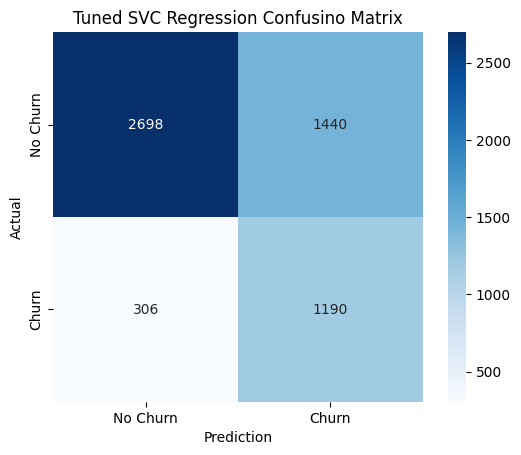

In [46]:
svc = SVC(probability = True, **svc_best_params)
y_scores = cross_val_predict(svc, X_train, y_train, cv=5, method='decision_function')
y_pred = (y_scores >= svc_threshold_score)

tuned_svc_confusion_matrix = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(tuned_svc_confusion_matrix, 'Tuned SVC Regression')

Note from the data above:
- Hyperparameter tuning did not significantly improve the score for SVC as well. I will stick with the previous one with no hyperparameter tuning. Let's try the model with the test data.

### 8.2.3. Evaluate a Model with the Test Set <a id = 8.2.3></a>
[Return to Table of Contents](#0)

Accuracy: 0.709
Precision: 0.471
Recall: 0.81
F1: 0.596


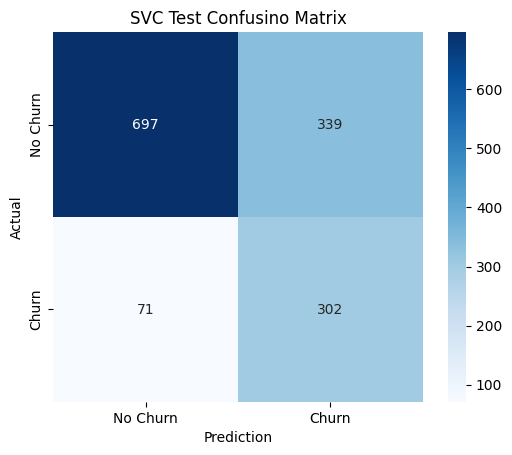

In [47]:
svc = SVC(probability = True)

svc.fit(X_train, y_train)
y_probs = svc.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= svc_decision_threshold)

svc_test_confusion_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)}')
print(f'Precision: {precision_score(y_test, y_pred).round(3)}')
print(f'Recall: {recall_score(y_test, y_pred).round(3)}')
print(f'F1: {f1_score(y_test, y_pred).round(3)}')
beautified_confusion_matrix(svc_test_confusion_matrix, "SVC Test")

### 8.2.4. ROC and AUC <a id = 8.2.4></a>
[Return to Table of Contents](#0)

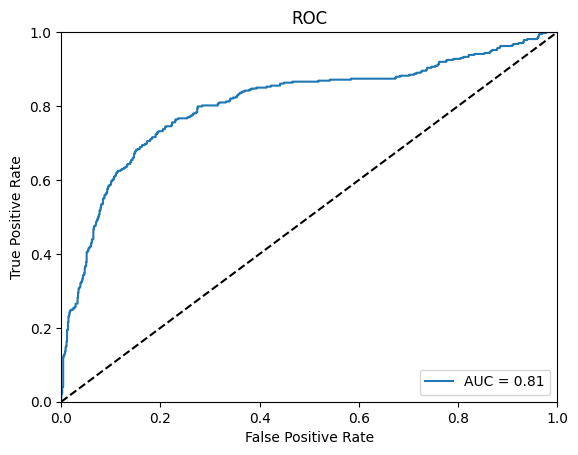

In [48]:
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_test, y_probs)
svc_roc_auc = auc(svc_fpr, svc_tpr)

plt.title('ROC')
plt.plot(svc_fpr, svc_tpr, label = 'AUC = %0.2f' % svc_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'k--', label = 'Random Guess')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

## 8.3. Decision Tree <a id = 8.3></a>
[Return to Table of Contents](#0)

_Decision Trees_ are versatile ML algorithms that can perform both classification and regression tasks. Decision trees are also the fundamental components of random forests, which are among the most powerful ML algorithms available today.

Accuracy: 0.998
Precision: 0.999
Recall: 0.993
F1: 0.996


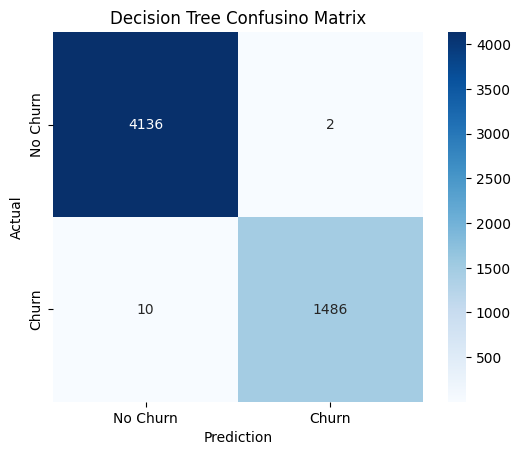

In [49]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_train)

dt_confusion_matrix = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(dt_confusion_matrix, "Decision Tree")

Notes from the data above:
- It is clearly overfitting the training set. 
- In the default setting, there is no specified maximum depth (max_depth), which allows the tree to grow until it captures ALL information in the training data. This causes the model to capture noise and outliers in the training data, leading to overfitting. you can see how deep the tree grew by visualizing the trained decision tree.

### 8.3.1. Visualizing a Decision Tree <a id = 8.3.1></a>
[Return to Table of Contents](#0)

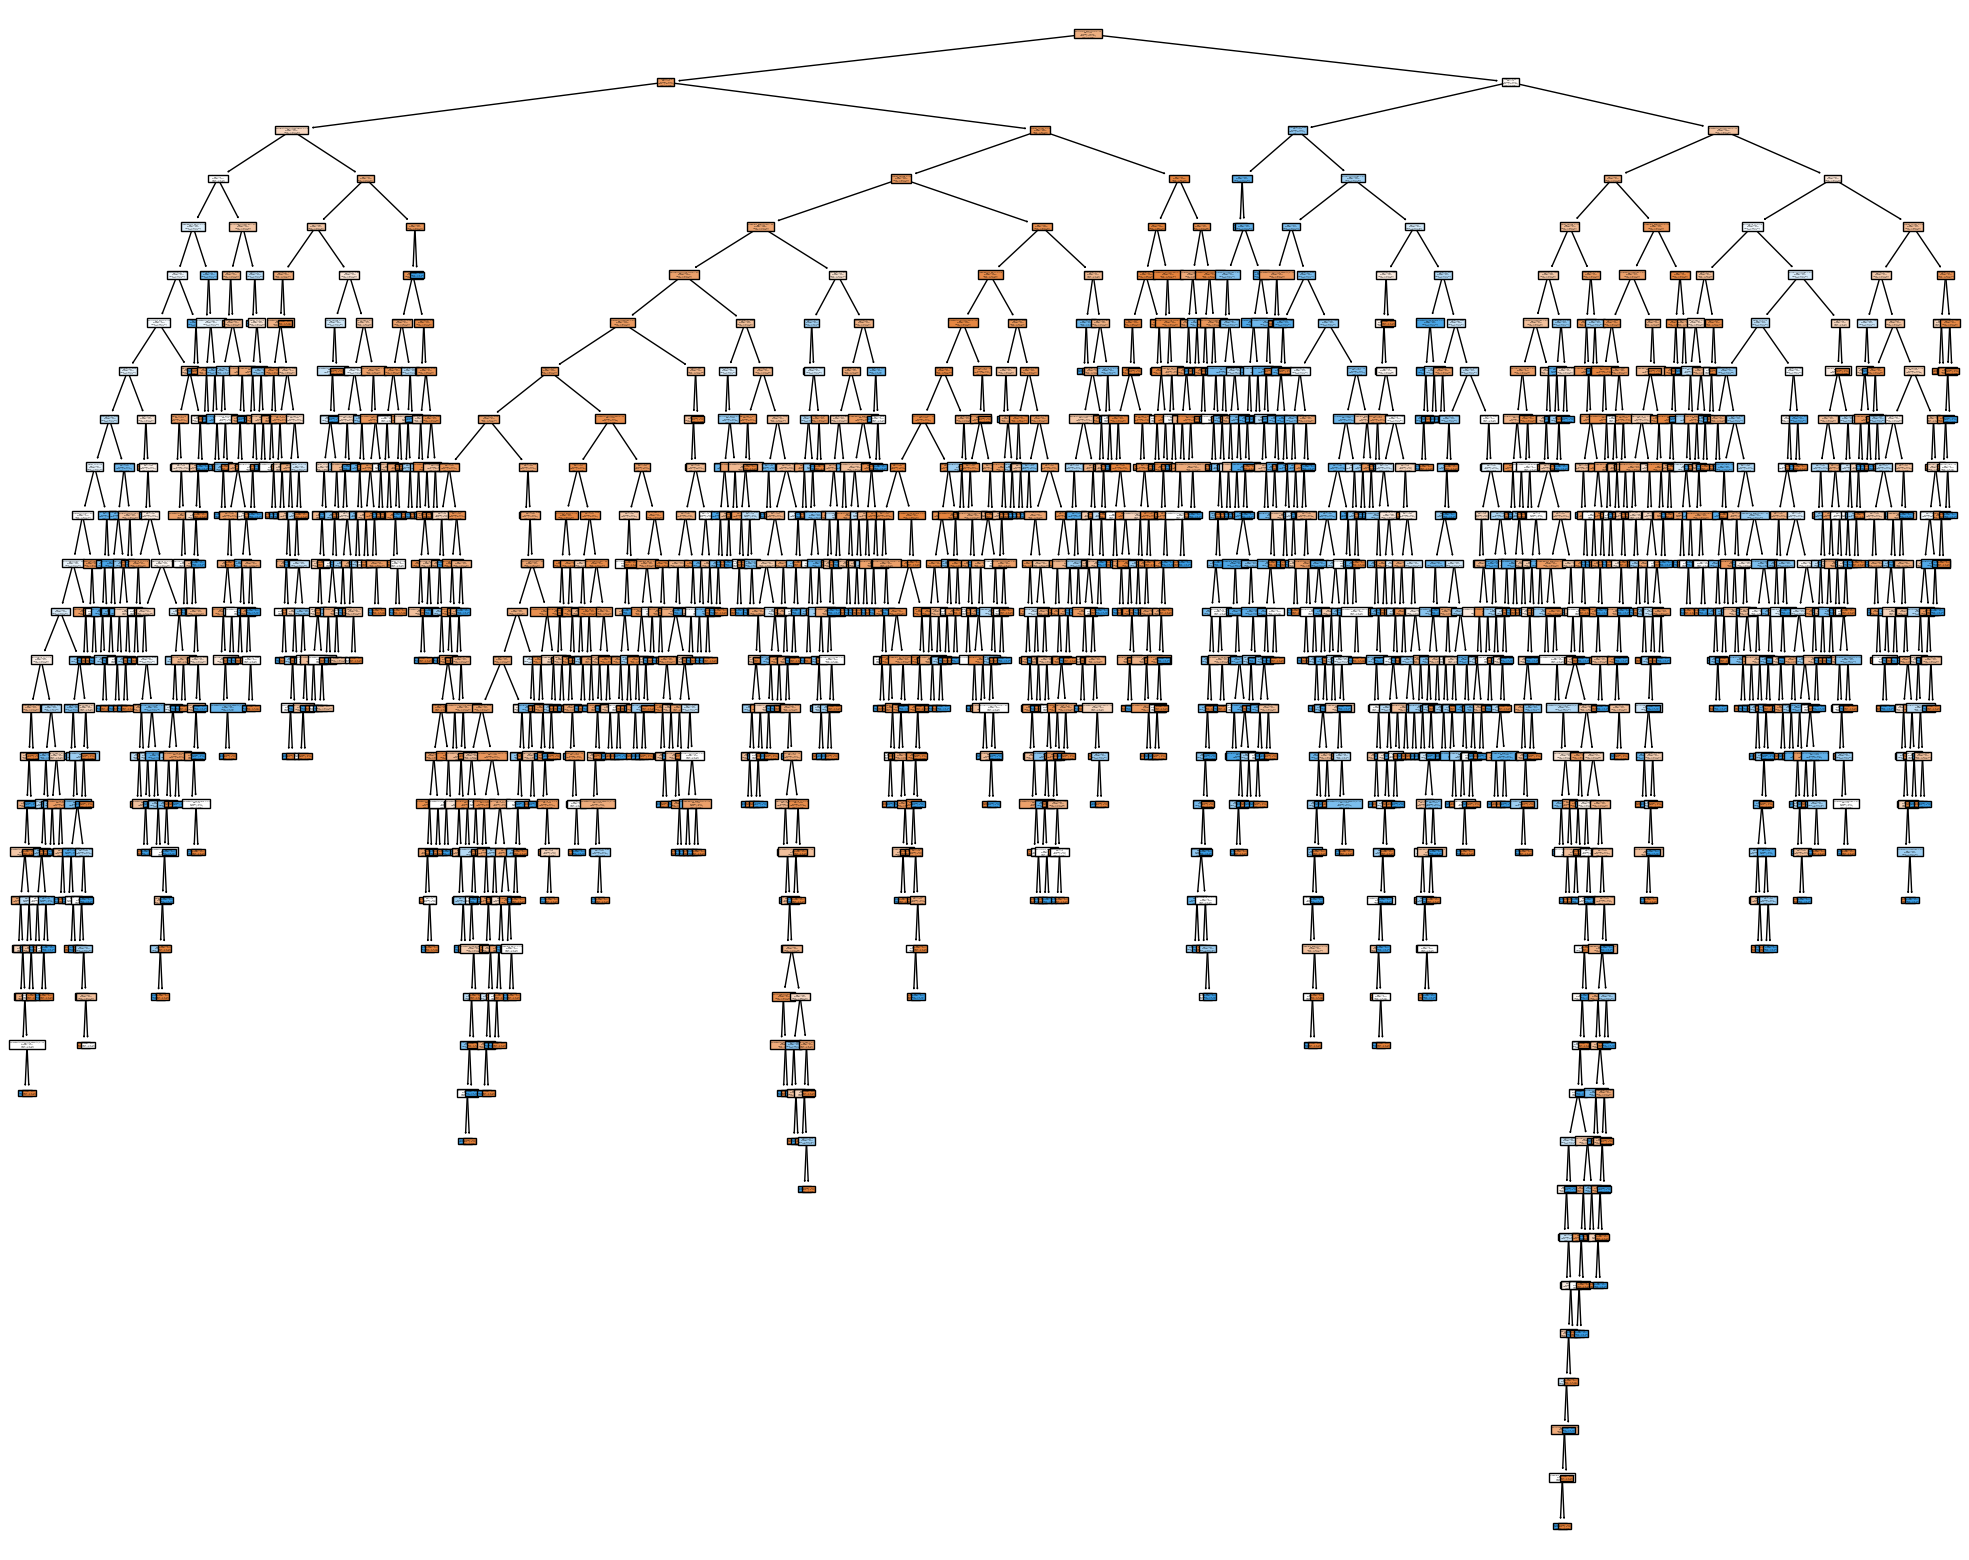

In [50]:
fig = plt.figure(figsize = (25, 20))
plot_tree(
    dt,
    feature_names = X_train.columns,
    class_names = ["No Churn", "Churn"],
    impurity = True,
    proportion = True,
    filled = True);

### 8.3.2. Feature Importance <a id = 8.3.2></a>
[Return to Table of Contents](#0)

Decision trees also allow us to see the relative importance of each attribute for making accurate predictions.

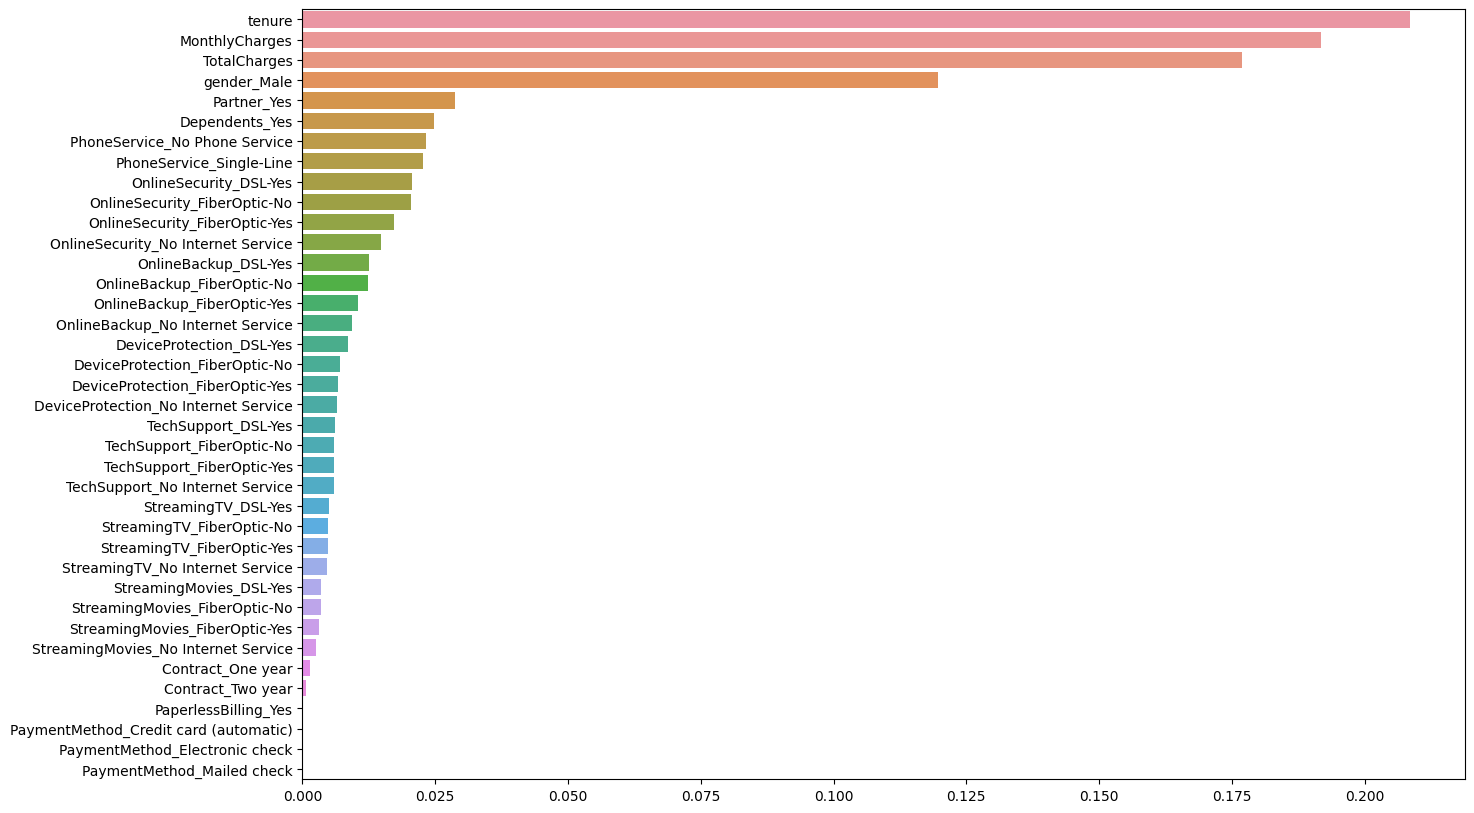

In [51]:
fig = plt.figure(figsize = (15, 10))
sns.barplot(x = np.sort(dt.feature_importances_)[::-1], y = X_train.columns);

With this information, we may want to try dropping some of the less useful features.

### 8.3.3. Hyperparameter Tuning <a id = 8.3.3></a>
[Return to Table of Contents](#0)

Decision trees have a lot of parameters we can tune.

In [52]:
dt = DecisionTreeClassifier()

params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': np.arange(2, 39),
    'max_leaf_nodes': np.arange(2, 21),
    'min_samples_split': np.arange(2, 11),
    'max_depth': np.arange(2, 21),
    'min_samples_leaf': np.arange(2, 21),
    'class_weight': [None, 'balanced', {0:1, 1:2}, {0:1, 1:3}]
}

rs = RandomizedSearchCV(
    dt, params, n_iter=50, cv=10, random_state=42, n_jobs = -1
)

rs.fit(X_train, y_train)

rs.best_params_

{'min_samples_split': 6,
 'min_samples_leaf': 5,
 'max_leaf_nodes': 14,
 'max_features': 30,
 'max_depth': 11,
 'criterion': 'log_loss',
 'class_weight': None}

In [53]:
dt = DecisionTreeClassifier()

params = {
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [4,5,6],
    'max_leaf_nodes': [15, 16, 17],
    'max_features': [32,33, 34],
    'max_depth': [13, 14, 15],
    'criterion': ['log_loss'],
    'class_weight': [None]
}

grid = GridSearchCV(
    dt, params, cv=5, n_jobs = -1
)

grid.fit(X_train, y_train)

dt_best_params = grid.best_params_
dt_best_params

{'class_weight': None,
 'criterion': 'log_loss',
 'max_depth': 14,
 'max_features': 33,
 'max_leaf_nodes': 17,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [54]:
dt_best_params = {'class_weight': None,
                  'criterion': 'log_loss',
                  'max_depth': 14,
                  'max_features': 32,
                  'max_leaf_nodes': 16,
                  'min_samples_leaf': 4,
                  'min_samples_split': 2}

Accuracy: 0.789
Precision: 0.636
Recall: 0.482
F1: 0.548


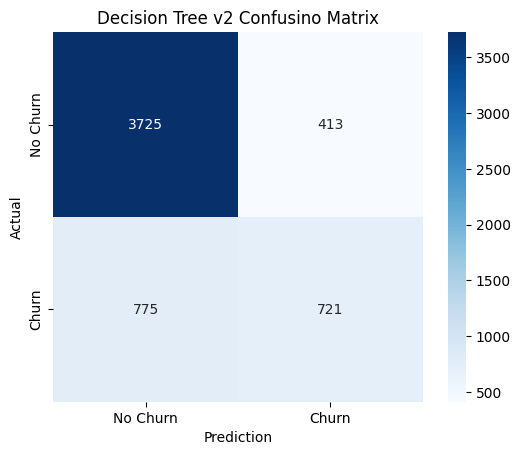

In [55]:
dt = DecisionTreeClassifier(**dt_best_params)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_train)

dt_confusion_matrix_v2 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(dt_confusion_matrix_v2, "Decision Tree v2")

### 8.3.4. Precision-Recall Curve <a id = 8.3.4></a>
[Return to Table of Contents](#0)

For the decision tree, we tuned hyperparameters first because if we plot the precision-recall curve by using a decision tree with no hyperparameter tuning, it will overfit the data until it captures all the information, and we cannot plot a useful precision-recall curve. Also, decision trees do not have a "decision function" method, so I will only use the "predict_proba" method.

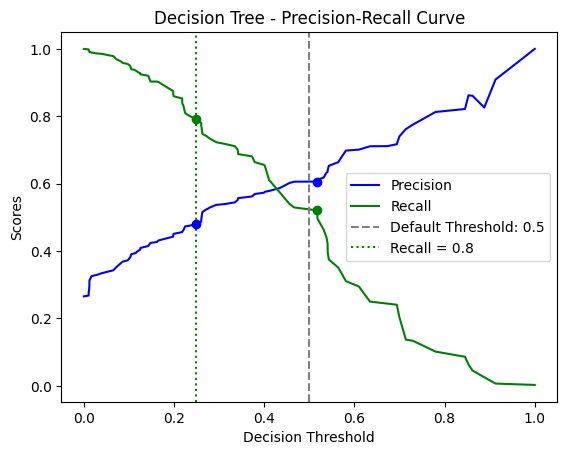

In [56]:
y_probs = cross_val_predict(dt, X_train, y_train, cv=5, method='predict_proba')[:, 1]

precision_recall_curve_using_proba(y_train, y_probs, "Decision Tree")

In [57]:
dt_decision_threshold = decision_threshold(y_train, y_probs)
dt_decision_threshold

0.24904214559386972

Accuracy: 0.704
Precision: 0.467
Recall: 0.818
F1: 0.595


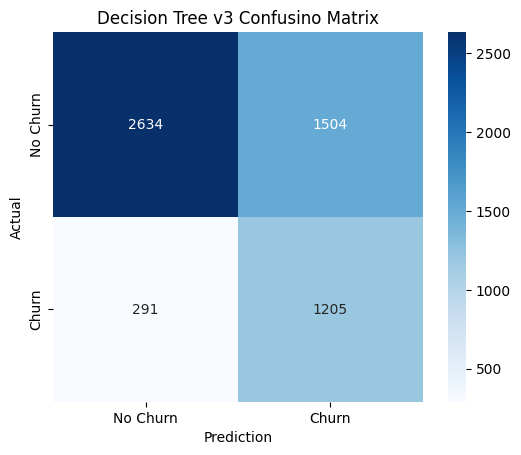

In [58]:
dt = DecisionTreeClassifier(**dt_best_params)
y_probs = cross_val_predict(dt, X_train, y_train, cv=5, method='predict_proba')[:, 1]
y_pred = (y_probs >= dt_decision_threshold)

dt_confusion_matrix_v3 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(svc_confusion_matrix_v2, "Decision Tree v3")

### 8.3.5. Evaluate a Model with the Test Set <a id = 8.3.5></a>
[Return to Table of Contents](#0)

Accuracy: 0.764
Precision: 0.538
Recall: 0.783
F1: 0.638


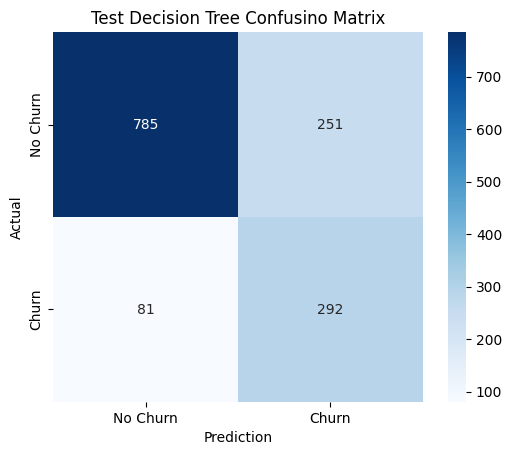

In [59]:
dt = DecisionTreeClassifier(**dt_best_params)

dt.fit(X_train, y_train)
y_probs = dt.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= dt_decision_threshold)

dt_test_confusion_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)}')
print(f'Precision: {precision_score(y_test, y_pred).round(3)}')
print(f'Recall: {recall_score(y_test, y_pred).round(3)}')
print(f'F1: {f1_score(y_test, y_pred).round(3)}')
beautified_confusion_matrix(dt_test_confusion_matrix, "Test Decision Tree")

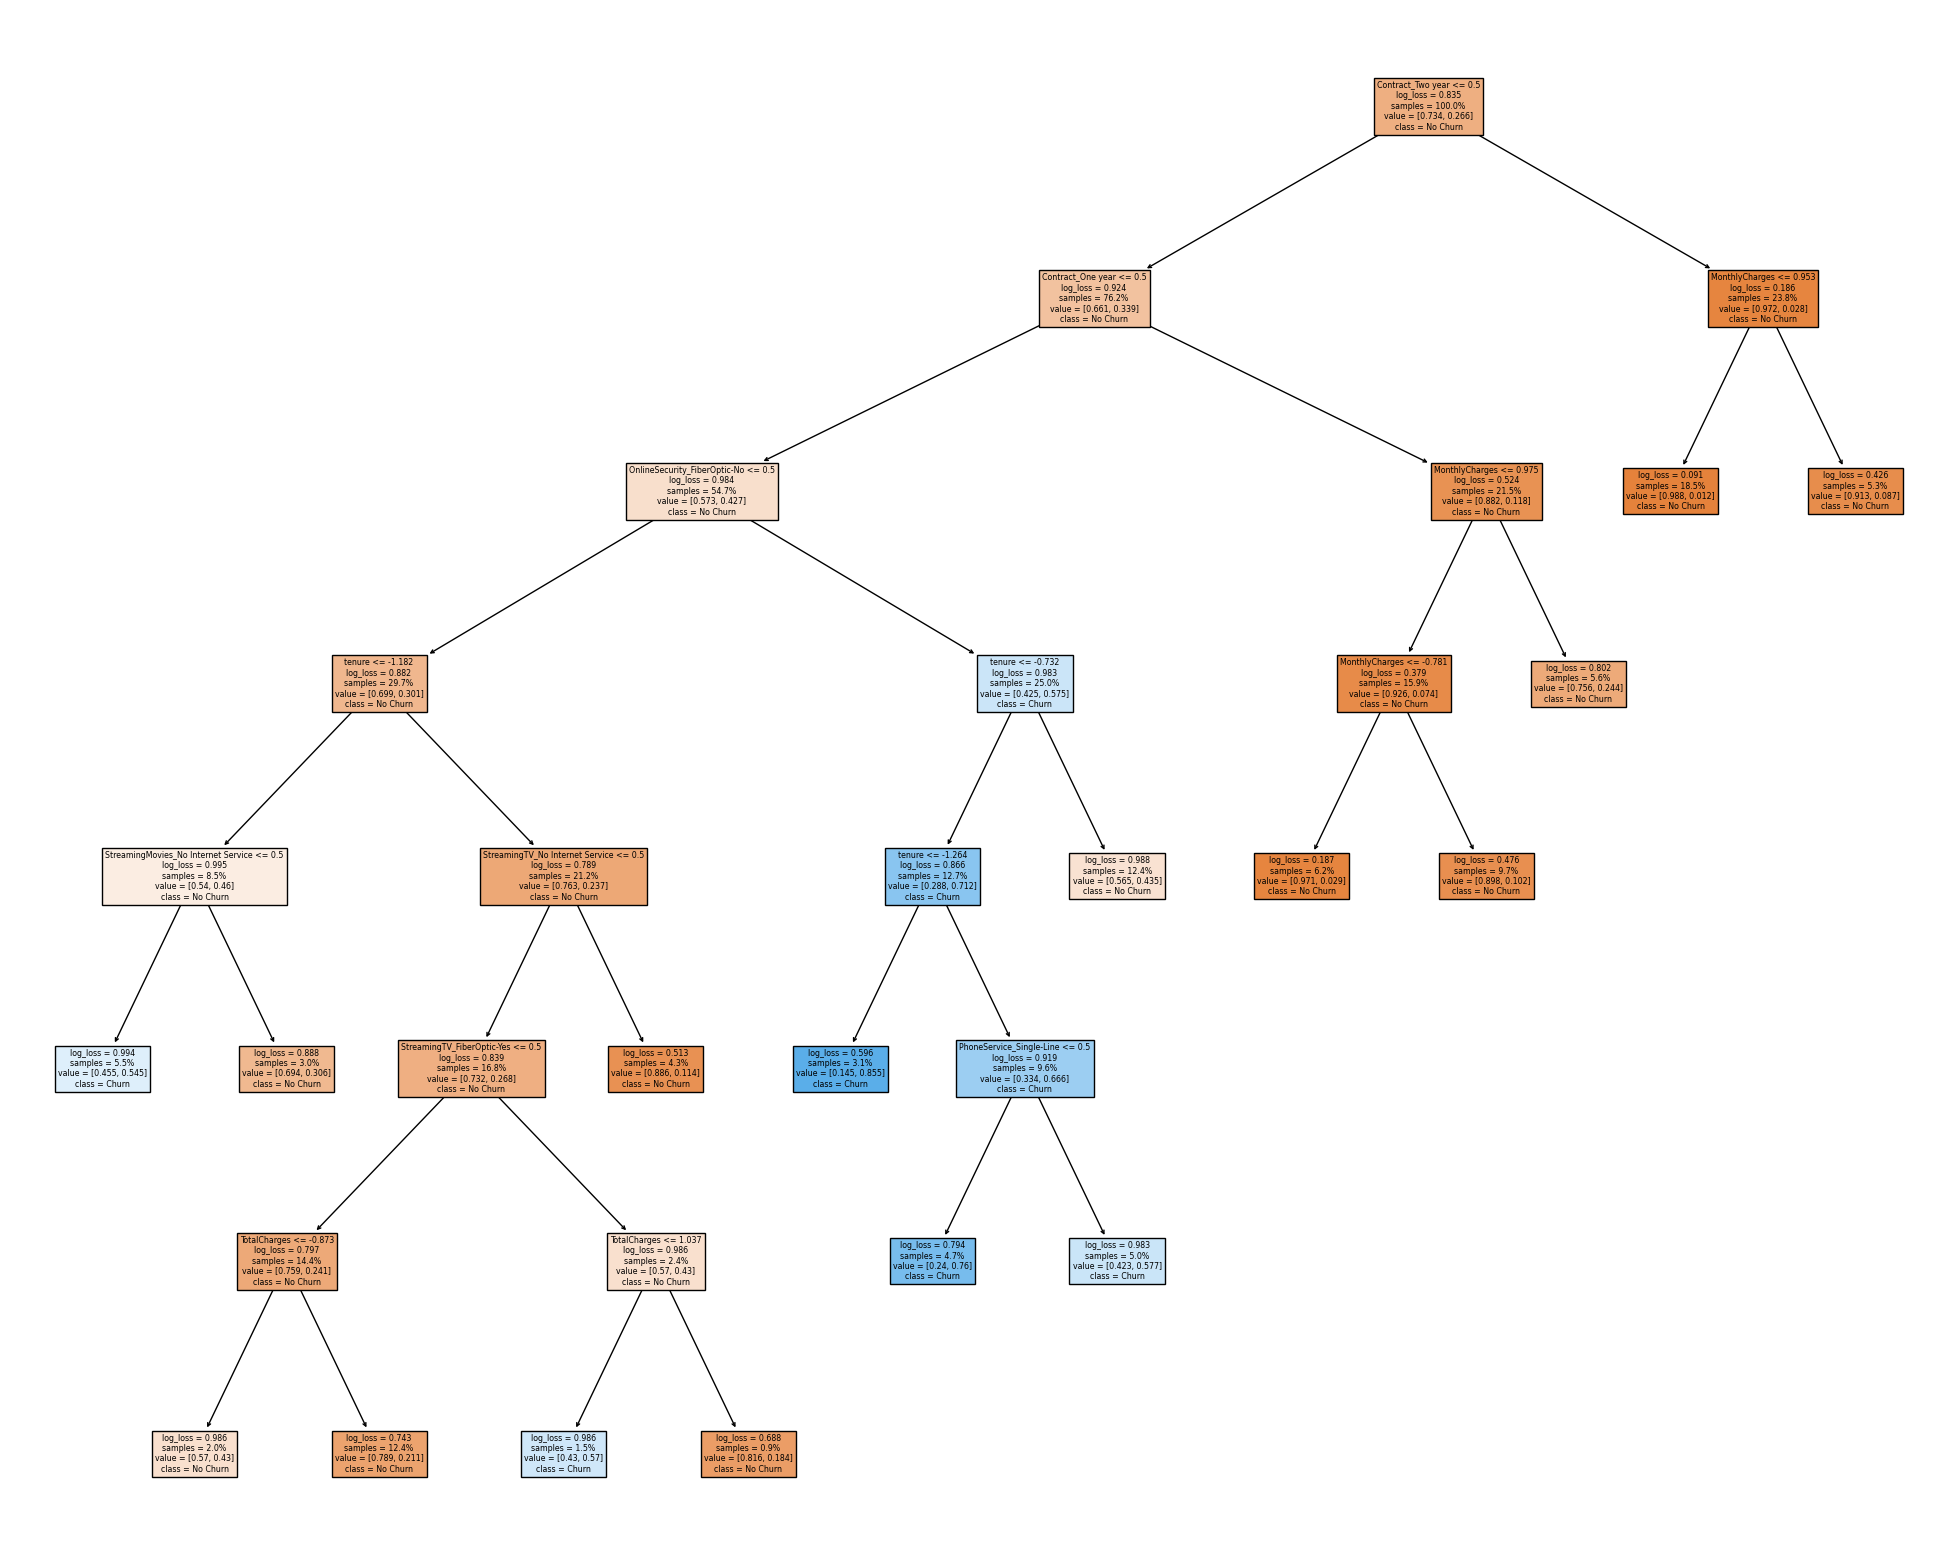

In [60]:
fig = plt.figure(figsize = (25, 20))
plot_tree(
    dt,
    feature_names = X_train.columns,
    class_names = ["No Churn", "Churn"],
    impurity = True,
    proportion = True,
    filled = True);

Note from the data above:
- Decision tree performed better than SVC but worse than Logistic Regression on the test data.

### 8.3.6. ROC and AUC <a id = 8.3.6></a>
[Return to Table of Contents](#0)

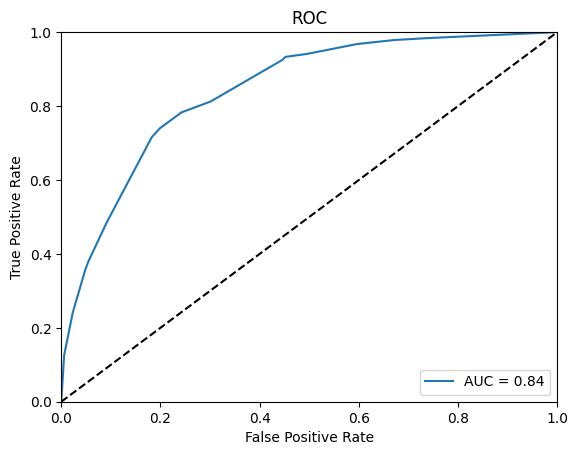

In [61]:
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, y_probs)
dt_roc_auc = auc(dt_fpr, dt_tpr)

plt.title('ROC')
plt.plot(dt_fpr, dt_tpr, label = 'AUC = %0.2f' % dt_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'k--', label = 'Random Guess')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

## 8.4. Random Forest <a id = 8.4></a>
[Return to Table of Contents](#0)

_Random Forest_ is an ensemble of decision trees. The random forest algorithm introduces extra randomness when growing trees; instead of searching for teh very best feature when splitting a node, it searches for the best feature among a random subset of features. The algorithm results in greater tree diversity, which trades a higher bias for a lower variance, generally yielding an overall better model. 

Accuracy: 0.8
Precision: 0.687
Recall: 0.457
F1: 0.549


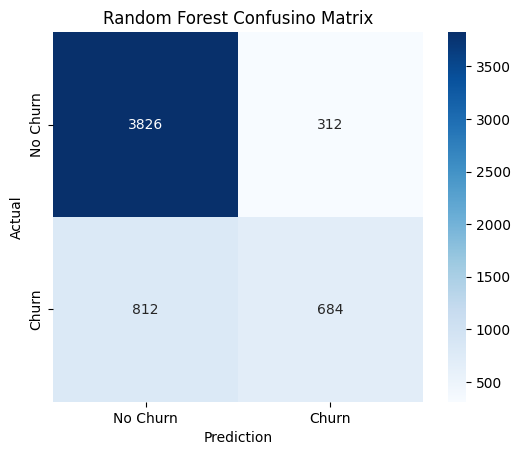

In [62]:
dt_best_params = {'class_weight': None,
                  'criterion': 'log_loss',
                  'max_depth': 13,
                  'max_features': 32,
                  'max_leaf_nodes': 16,
                  'min_samples_leaf': 5,
                  'min_samples_split': 3}

rf = RandomForestClassifier(random_state = 42, **dt_best_params)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)

rf_confusion_matrix = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(rf_confusion_matrix, "Random Forest")

### 8.4.1. Hyperparameter Tuning <a id = 8.4.1></a>
[Return to Table of Contents](#0)

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

In [63]:
rf = RandomForestClassifier()

params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': np.arange(10, 21),
    'min_samples_split': np.arange(2, 11),
    'max_depth': np.arange(2, 21),
    'min_samples_leaf': np.arange(2, 11),
    'class_weight': [None],
    'n_estimators': np.arange(start = 100, stop = 1100, step = 100),
    'bootstrap': [True, False],
    'max_samples': [None, .3, .5, .9]
}

rs = RandomizedSearchCV(
    rf, params, n_iter=50, cv=10, random_state=42, n_jobs = -1
)

rs.fit(X_train, y_train)

rs.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 9,
 'max_samples': None,
 'max_leaf_nodes': 19,
 'max_features': None,
 'max_depth': 20,
 'criterion': 'gini',
 'class_weight': None,
 'bootstrap': True}

In [64]:
params = {
    'n_estimators': np.arange(start = 380, stop = 420, step = 10),
    'min_samples_split': [6],
    'min_samples_leaf': [2,3,4],
    'max_samples': [None, 0.9,],
    'max_leaf_nodes': [3],
    'max_features': [None, 'sqrt'],
    'max_depth': [19],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': [None],
    'bootstrap': [True]
}

grid = GridSearchCV(
    rf, params, cv=10, n_jobs = -1
)

grid.fit(X_train, y_train)

rf_best_params = grid.best_params_
rf_best_params

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 19,
 'max_features': None,
 'max_leaf_nodes': 3,
 'max_samples': None,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 400}

In [65]:
rf_best_params = {'bootstrap': True,
                  'class_weight': None,
                  'criterion': 'gini',
                  'max_depth': 19,
                  'max_features': None,
                  'max_leaf_nodes': 3,
                  'max_samples': 0.9,
                  'min_samples_leaf': 3,
                  'min_samples_split': 6,
                  'n_estimators': 410}

Accuracy: 0.787
Precision: 0.706
Recall: 0.338
F1: 0.457


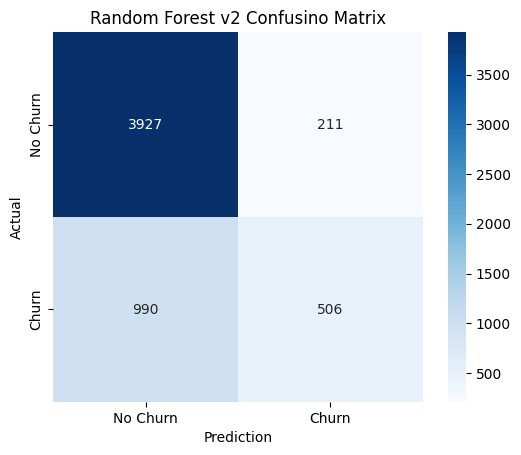

In [66]:
rf = RandomForestClassifier(**rf_best_params)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)

rf_confusion_matrix_v2 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(rf_confusion_matrix_v2, "Random Forest v2")

### 8.4.2. Precision-Recall Curve <a id = 8.4.2></a>
[Return to Table of Contents](#0)

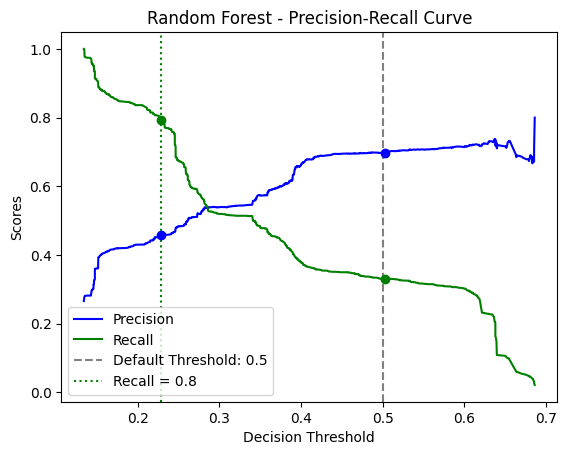

In [67]:
rf = RandomForestClassifier(**rf_best_params)

y_probs = cross_val_predict(rf, X_train, y_train, cv=5, method = "predict_proba")[:, 1]

precision_recall_curve_using_proba(y_train, y_probs, "Random Forest")

In [68]:
rf_decision_threshold = decision_threshold(y_train, y_probs)
rf_decision_threshold

0.22817662203519987

Accuracy: 0.68
Precision: 0.441
Recall: 0.774
F1: 0.562


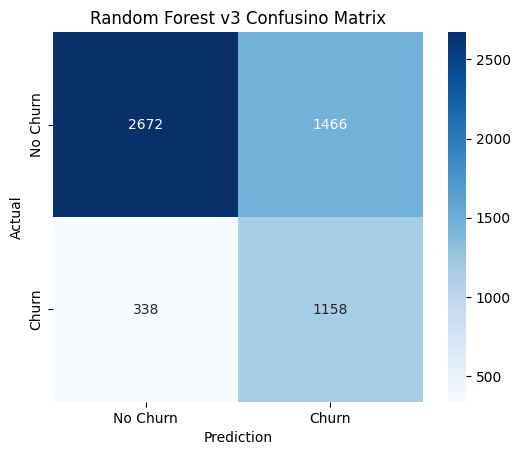

In [69]:
rf = RandomForestClassifier(**rf_best_params)
y_probs = cross_val_predict(rf, X_train, y_train, cv=3, method='predict_proba')[:, 1]
y_pred = (y_probs >= rf_decision_threshold)

rf_confusion_matrix_v3 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(rf_confusion_matrix_v3, "Random Forest v3")

### 8.4.3. Evaluate a Model with the Test Set <a id = 8.4.3></a>
[Return to Table of Contents](#0)

Accuracy: 0.722
Precision: 0.486
Recall: 0.812
F1: 0.608


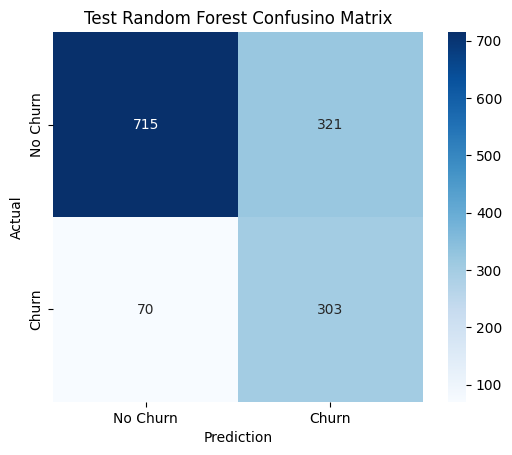

In [70]:
rf.fit(X_train, y_train)
y_probs = rf.predict_proba(X_test)[:,1]
y_pred = (y_probs >= rf_decision_threshold)

rf_test_confusion_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)}')
print(f'Precision: {precision_score(y_test, y_pred).round(3)}')
print(f'Recall: {recall_score(y_test, y_pred).round(3)}')
print(f'F1: {f1_score(y_test, y_pred).round(3)}')
beautified_confusion_matrix(rf_test_confusion_matrix, "Test Random Forest")

### 8.4.4. ROC and AUC <a id = 8.4.4></a>
[Return to Table of Contents](#0)

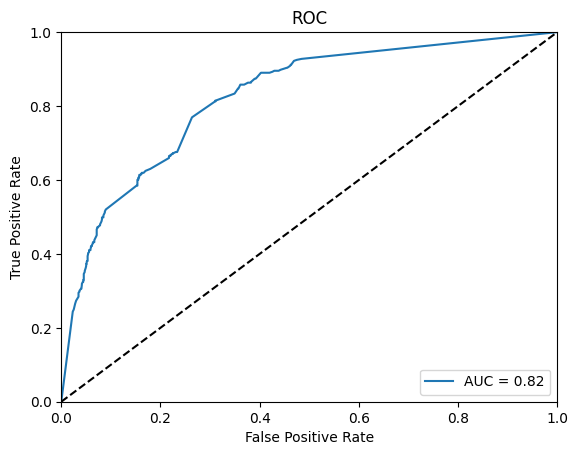

In [71]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_probs)
rf_roc_auc = auc(rf_fpr, rf_tpr)

plt.title('ROC')
plt.plot(rf_fpr, rf_tpr, label = 'AUC = %0.2f' % rf_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'k--', label = 'Random Guess')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

### 8.4.5. Feature Importance <a id = 8.4.5></a>
[Return to Table of Contents](#0)

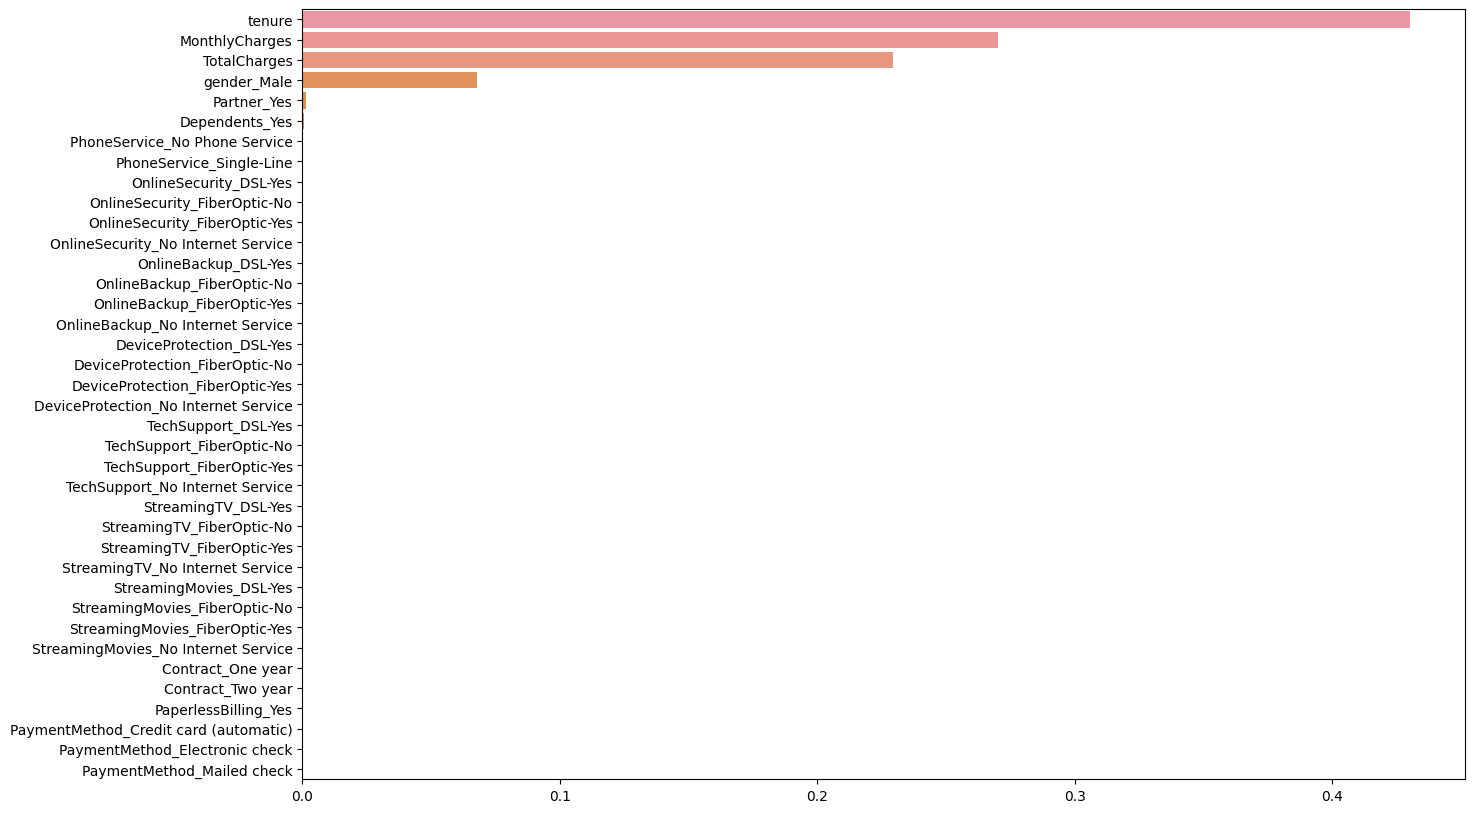

In [72]:
fig = plt.figure(figsize = (15, 10))
sns.barplot(x = np.sort(rf.feature_importances_)[::-1], y = X_train.columns);

## 8.5. AdaBoost <a id = 8.5></a>
[Return to Table of Contents](#0)

_Boosting_ refers to any ensemble method that can combineseveral weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are _AdaBoost_ and _Gradient Boosting_.

_AdaBoost_ pays a bit more attention to the training instances that the predecessor underfit. This results in new predictors focusing more and more on the hard cases. When training an AdaBoost classifier, the algorithm first trains a base classifier (such as a decision tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on. 

Accuracy: 0.806
Precision: 0.667
Recall: 0.539
F1: 0.597


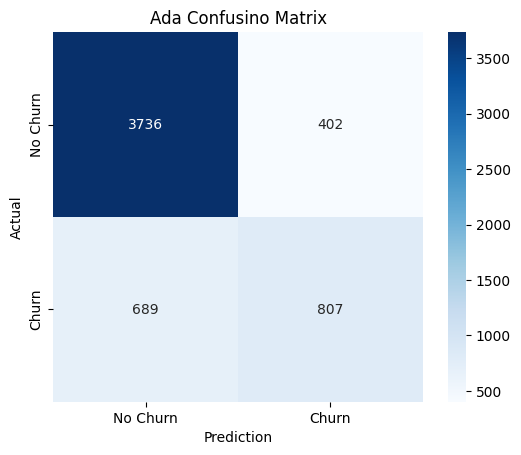

In [73]:
ada = AdaBoostClassifier(random_state = 42)

ada.fit(X_train, y_train)

y_pred = ada.predict(X_train)

ada_confusion_matrix = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(ada_confusion_matrix, "Ada")

### 8.5.1. Hyperparameter Tuning <a id = 8.5.1></a>
[Return to Table of Contents](#0)

In [74]:
ada = AdaBoostClassifier()

params = {
    'learning_rate': [.001, .01, .1, .2],
    'n_estimators': np.arange(start = 100, stop = 1100, step = 100),
    'algorithm': ['SAMME', 'SAMME.R']
}

rs = RandomizedSearchCV(
    ada, params, n_iter=50, cv=10, random_state=42, n_jobs = -1
)

rs.fit(X_train, y_train)

ada_best_params = rs.best_params_
ada_best_params

{'n_estimators': 300, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'}

In [75]:
ada_best_params = {'n_estimators': 300, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'}

Accuracy: 0.803
Precision: 0.671
Recall: 0.504
F1: 0.576


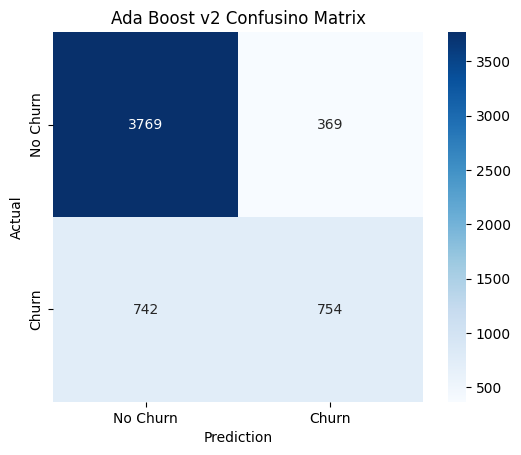

In [76]:
ada = AdaBoostClassifier(**ada_best_params)
ada.fit(X_train, y_train)

y_pred = ada.predict(X_train)

ada_confusion_matrix_v2 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(ada_confusion_matrix_v2, "Ada Boost v2")

### 8.5.2. Precision-Recall Curve <a id = 8.5.2></a>
[Return to Table of Contents](#0)

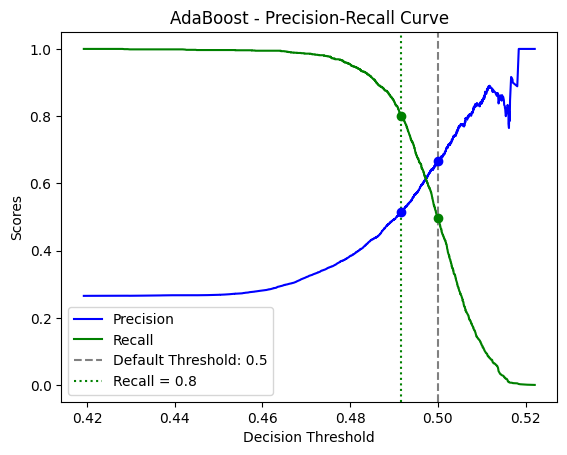

In [77]:
ada = AdaBoostClassifier(**ada_best_params)

y_probs = cross_val_predict(ada, X_train, y_train, cv=5, method = "predict_proba")[:, 1]

precision_recall_curve_using_proba(y_train, y_probs, "AdaBoost")

In [78]:
ada_decision_threshold = decision_threshold(y_train, y_probs)
ada_decision_threshold

0.49170279489420293

Accuracy: 0.746
Precision: 0.514
Recall: 0.793
F1: 0.624


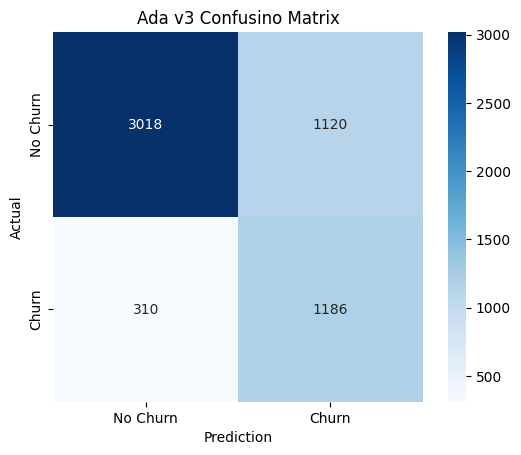

In [79]:
ada = AdaBoostClassifier(**ada_best_params)
y_probs = cross_val_predict(ada, X_train, y_train, cv=3, method='predict_proba')[:, 1]
y_pred = (y_probs >= ada_decision_threshold)

ada_confusion_matrix_v3 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(ada_confusion_matrix_v3, "Ada v3")

### 8.5.3. Evaluate a Model with the Test Set <a id = 8.5.3></a>
[Return to Table of Contents](#0)

Accuracy: 0.759
Precision: 0.528
Recall: 0.836
F1: 0.647


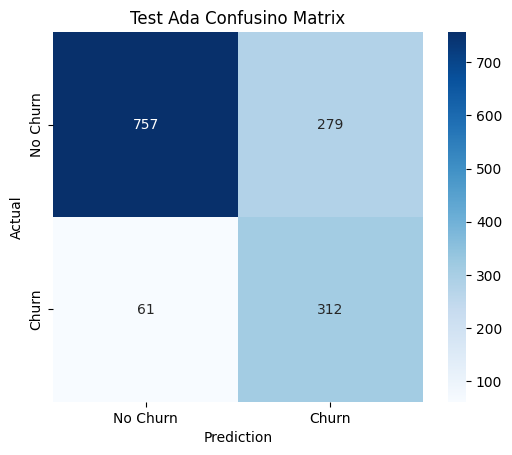

In [80]:
ada.fit(X_train, y_train)
y_probs = ada.predict_proba(X_test)[:,1]
y_pred = (y_probs >= ada_decision_threshold)

ada_test_confusion_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)}')
print(f'Precision: {precision_score(y_test, y_pred).round(3)}')
print(f'Recall: {recall_score(y_test, y_pred).round(3)}')
print(f'F1: {f1_score(y_test, y_pred).round(3)}')
beautified_confusion_matrix(ada_test_confusion_matrix, "Test Ada")

### 8.5.4. ROC and AUC <a id = 8.5.4></a>
[Return to Table of Contents](#0)

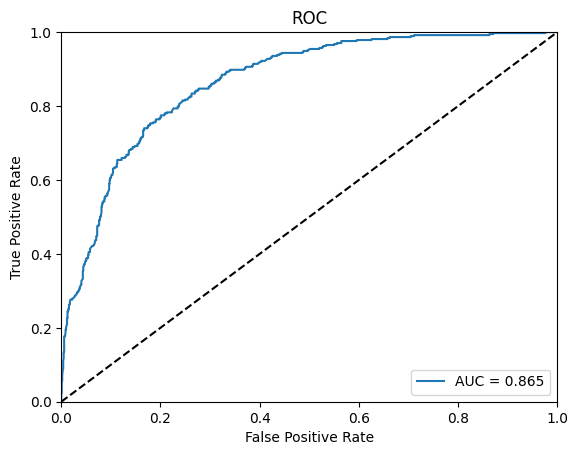

In [81]:
ada_fpr, ada_tpr, ada_thresholds = roc_curve(y_test, y_probs)
ada_roc_auc = auc(ada_fpr, ada_tpr)

plt.title('ROC')
plt.plot(ada_fpr, ada_tpr, label = 'AUC = %0.3f' % ada_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'k--', label = 'Random Guess')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

### 8.5.5. Feature Importance <a id = 8.5.5></a>
[Return to Table of Contents](#0)

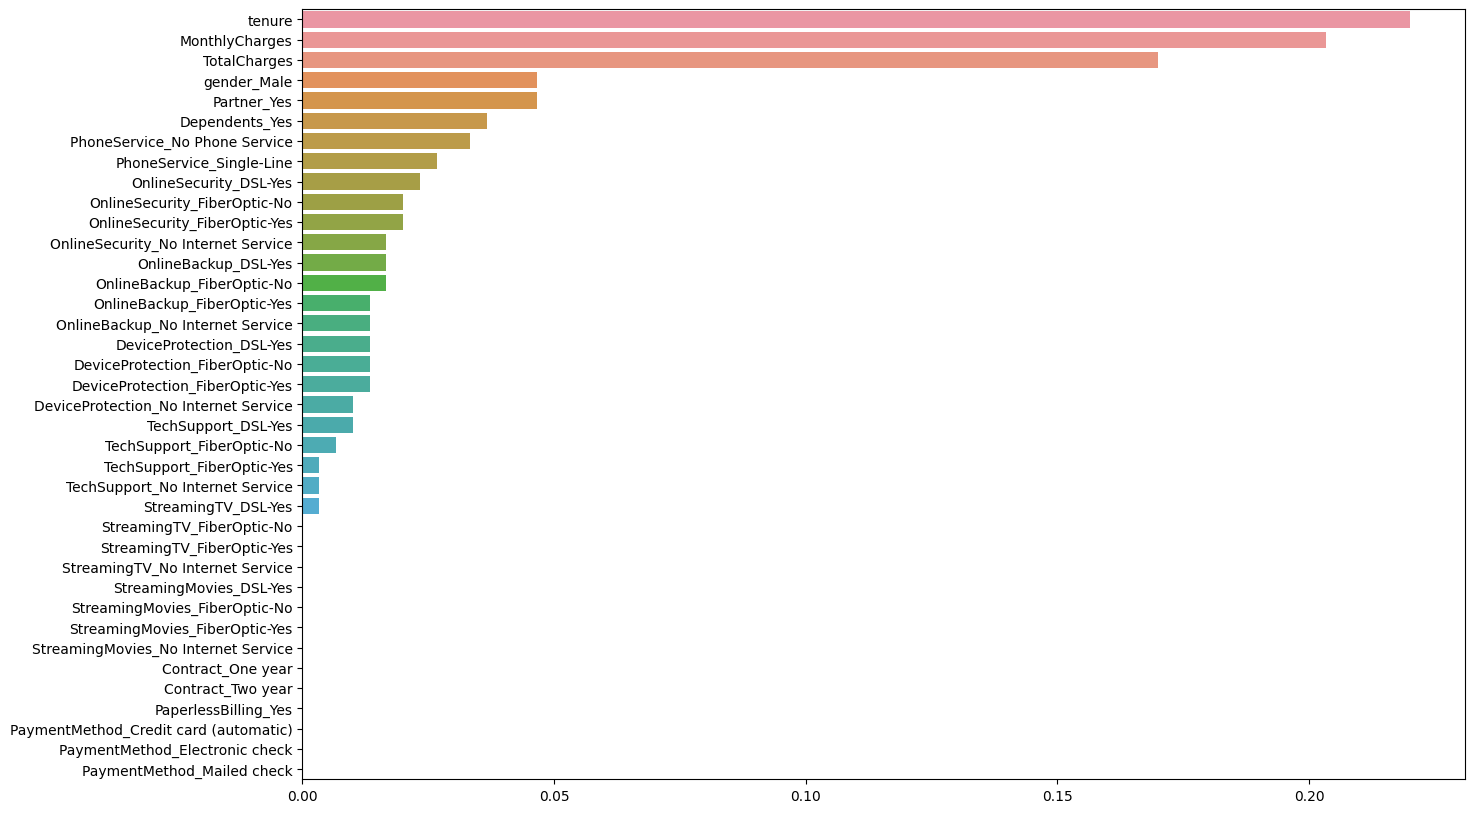

In [82]:
fig = plt.figure(figsize = (15, 10))
sns.barplot(x = np.sort(ada.feature_importances_)[::-1], y = X_train.columns);

## 8.6. Gradient Boosting <a id = 8.6></a>
[Return to Table of Contents](#0)

Just like AdaBoost, _Gradient Boosting_ works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, istead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

Accuracy: 0.823
Precision: 0.714
Recall: 0.556
F1: 0.625


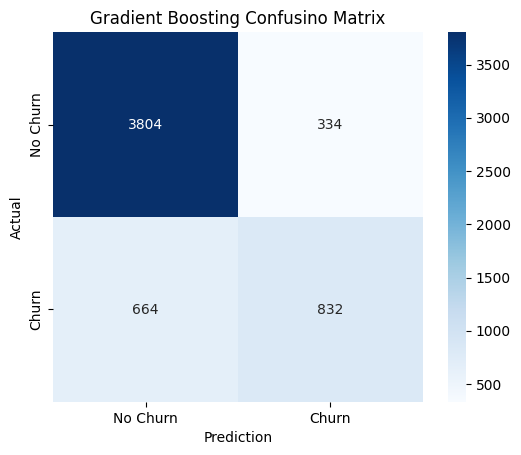

In [83]:
gb = GradientBoostingClassifier(random_state = 42)

gb.fit(X_train, y_train)

y_pred = gb.predict(X_train)

gb_confusion_matrix = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(gb_confusion_matrix, "Gradient Boosting")

### 8.6.1. Hyperparameter Tuning <a id = 8.5.1></a>
[Return to Table of Contents](#0)

Much like the RandomForestClassifier class, it has hyperparameters to control the growth of decision trees (e.g., max_depth, min_samples_leaf, etc.), as well as hyperparameters to control the ensemble training, such as the number of trees (n_estimators, etc.). The __learning rate__ hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.01, we will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better (_shrinkage_).

In [84]:
gb = GradientBoostingClassifier()

params = {
    'criterion': ['friedman_mse', 'squared_error'],
    'learning_rate': [.001, .01, .1, .2],
    'max_features': [None, 'sqrt'],
    'max_leaf_nodes': np.arange(2, 21),
    'min_samples_split': np.arange(2, 11),
    'max_depth': np.arange(2, 21),
    'min_samples_leaf': np.arange(2, 21),
    'n_estimators': np.arange(start = 100, stop = 1100, step = 100),
    'subsample': [0.8, 0.9, 1]
}

rs = RandomizedSearchCV(
    gb, params, n_iter=50, cv=10, random_state=42, n_jobs = -1
)

rs.fit(X_train, y_train)

gb_best_params = rs.best_params_
gb_best_params

{'subsample': 1,
 'n_estimators': 300,
 'min_samples_split': 8,
 'min_samples_leaf': 11,
 'max_leaf_nodes': 7,
 'max_features': None,
 'max_depth': 15,
 'learning_rate': 0.01,
 'criterion': 'squared_error'}

In [85]:
gb_best_params = {'subsample': 1,
                  'n_estimators': 300,
                  'min_samples_split': 8,
                  'min_samples_leaf': 11,
                  'max_leaf_nodes': 7,
                  'max_features': None,
                  'max_depth': 15,
                  'learning_rate': 0.01,
                  'criterion': 'squared_error'}

Accuracy: 0.81
Precision: 0.706
Recall: 0.484
F1: 0.574


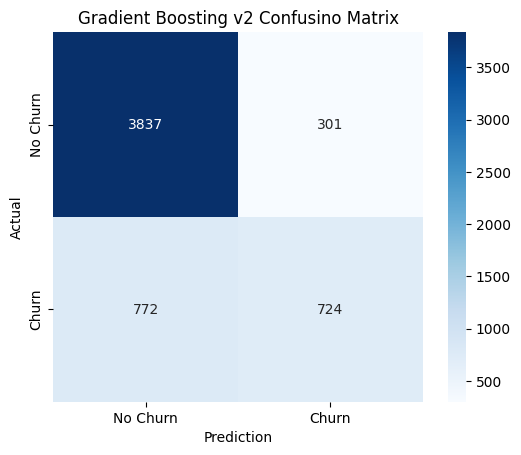

In [86]:
gb = GradientBoostingClassifier(**gb_best_params)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_train)

gb_confusion_matrix_v2 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(gb_confusion_matrix_v2, "Gradient Boosting v2")

### 8.6.2. Precision-Recall Curve <a id = 8.5.2></a>
[Return to Table of Contents](#0)

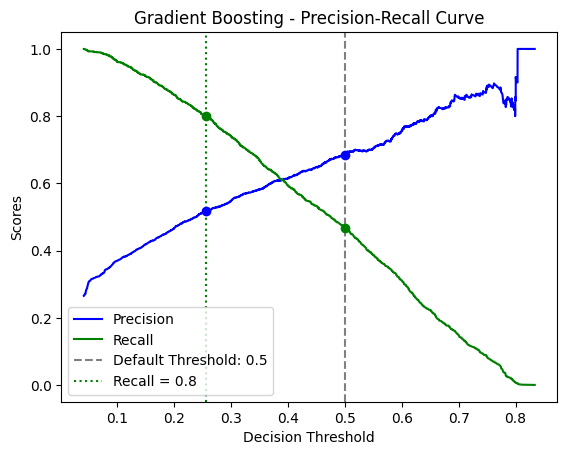

In [87]:
gb = GradientBoostingClassifier(**gb_best_params)

y_probs = cross_val_predict(gb, X_train, y_train, cv=5, method = "predict_proba")[:, 1]

precision_recall_curve_using_proba(y_train, y_probs, "Gradient Boosting")

In [88]:
gb_decision_threshold = decision_threshold(y_train, y_probs)
gb_decision_threshold

0.25643846280316274

Accuracy: 0.743
Precision: 0.511
Recall: 0.792
F1: 0.621


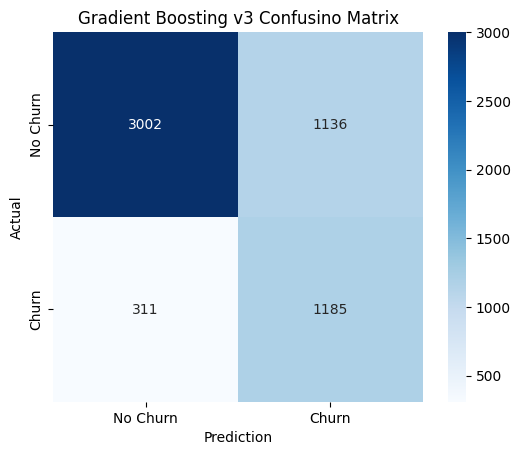

In [89]:
gb = GradientBoostingClassifier(**gb_best_params)
y_probs = cross_val_predict(gb, X_train, y_train, cv=3, method='predict_proba')[:, 1]
y_pred = (y_probs >= gb_decision_threshold)

gb_confusion_matrix_v3 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(gb_confusion_matrix_v3, "Gradient Boosting v3")

### 8.6.3. Evaluate a Model with the Test Set <a id = 8.6.3></a>
[Return to Table of Contents](#0)

Accuracy: 0.753
Precision: 0.521
Recall: 0.823
F1: 0.638


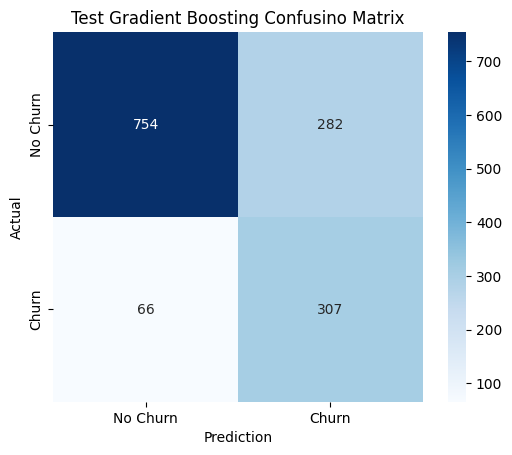

In [90]:
gb.fit(X_train, y_train)
y_probs = gb.predict_proba(X_test)[:,1]
y_pred = (y_probs >= gb_decision_threshold)

gb_test_confusion_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)}')
print(f'Precision: {precision_score(y_test, y_pred).round(3)}')
print(f'Recall: {recall_score(y_test, y_pred).round(3)}')
print(f'F1: {f1_score(y_test, y_pred).round(3)}')
beautified_confusion_matrix(gb_test_confusion_matrix, "Test Gradient Boosting")

### 8.6.4. ROC and AUC <a id = 8.6.4></a>
[Return to Table of Contents](#0)

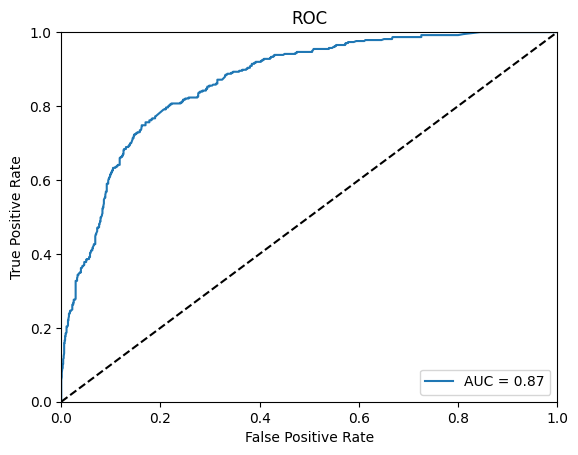

In [91]:
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, y_probs)
gb_roc_auc = auc(gb_fpr, gb_tpr)

plt.title('ROC')
plt.plot(gb_fpr, gb_tpr, label = 'AUC = %0.2f' % gb_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'k--', label = 'Random Guess')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

### 8.6.5. Feature Importance <a id = 8.6.5></a>
[Return to Table of Contents](#0)

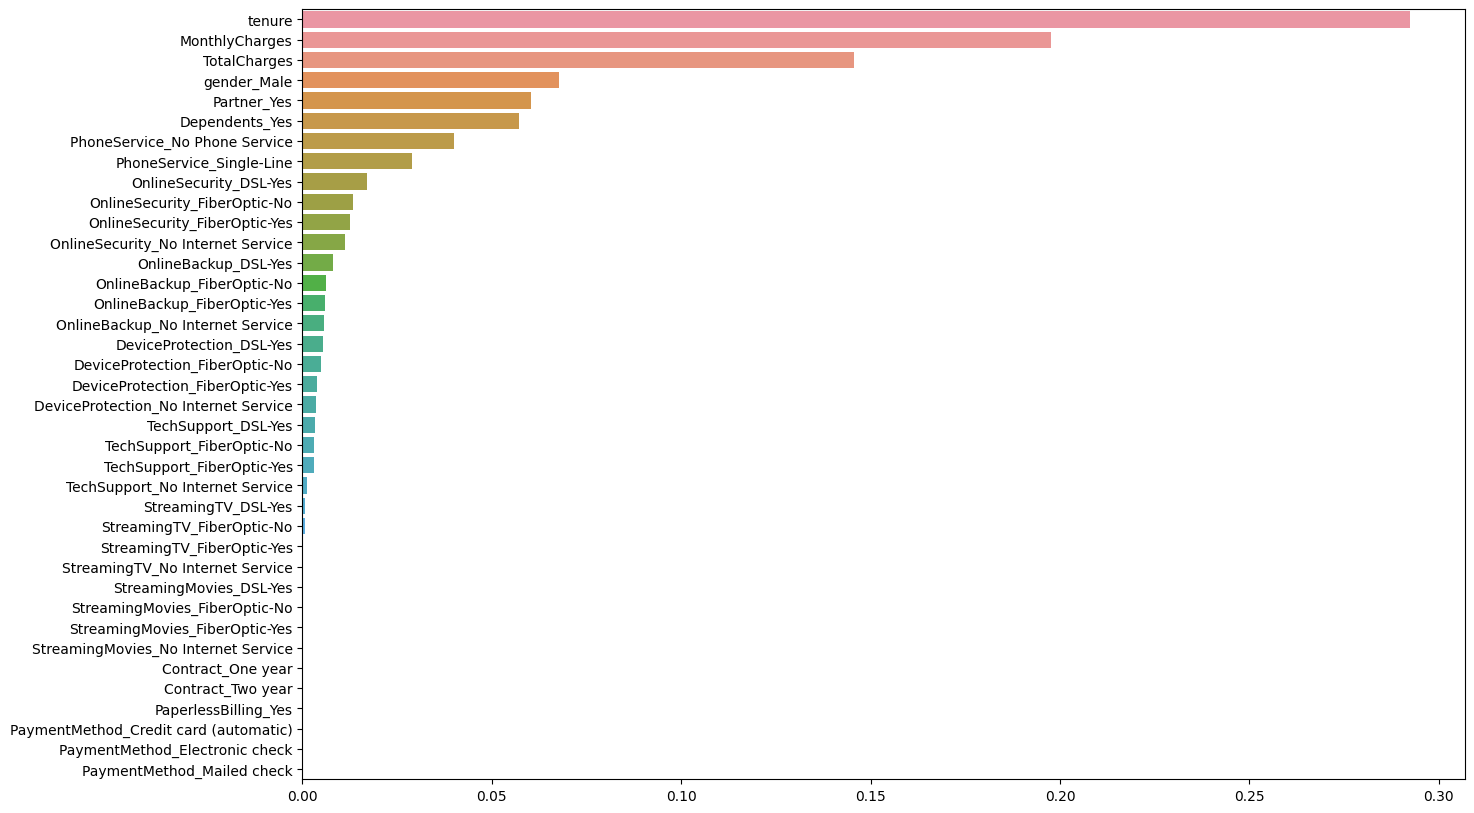

In [92]:
fig = plt.figure(figsize = (15, 10))
sns.barplot(x = np.sort(gb.feature_importances_)[::-1], y = X_train.columns);

## 8.7. Voting <a id = 8.7></a>
[Return to Table of Contents](#0)

We have trained a few classifiers so far, each one achieving about 80% recall and 40%-50% precision. We can aggregate the predictions of each classifier by using a _Voting Classifier_ class. There are _hard voting_ (the class that gets the most votes is the ensemble's prediction) or _soft voting_ (predict the class with the highest class probability, averaged over all the individual classifiers.).

Accuracy: 0.803
Precision: 0.715
Recall: 0.429
F1: 0.536


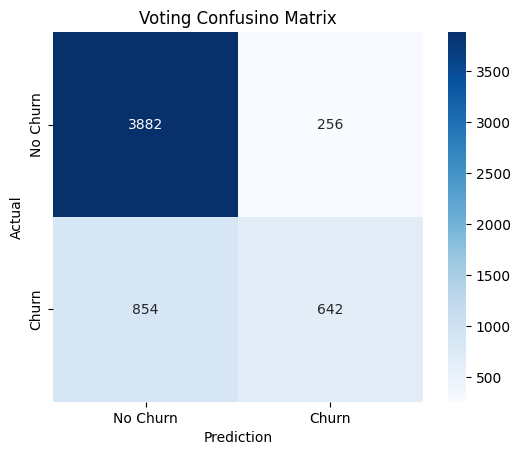

In [93]:
voting = VotingClassifier(
    estimators = [
        ('lr', LogisticRegression(random_state = 42)),
        ('svc', SVC(random_state = 42, probability = True)),
        ('dt', DecisionTreeClassifier(random_state = 42, **dt_best_params)),
        ('rf', RandomForestClassifier(random_state = 42, **rf_best_params)),
        ('ada', AdaBoostClassifier(random_state = 42, **ada_best_params)),
        ('gb', GradientBoostingClassifier(random_state = 42, **gb_best_params))
    ], 
    voting = 'soft')

voting.fit(X_train, y_train)
y_pred = voting.predict(X_train)

voting_confusion_matrix = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(voting_confusion_matrix, "Voting")

### 8.7.1. Precision-Recall Curve <a id = 8.7.1></a>
[Return to Table of Contents](#0)

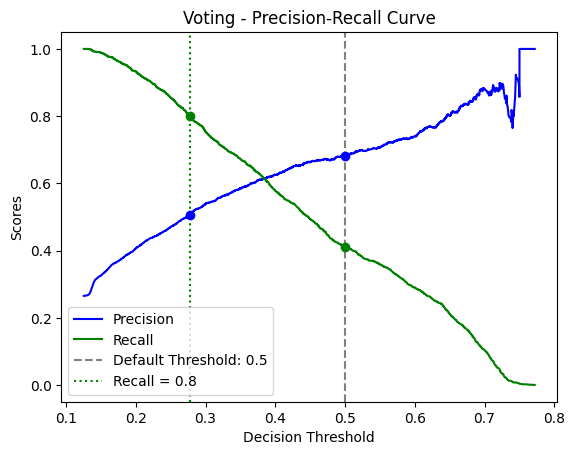

In [94]:
y_probs = cross_val_predict(voting, X_train, y_train, cv=5, method = "predict_proba")[:, 1]

precision_recall_curve_using_proba(y_train, y_probs, "Voting")

In [95]:
voting_decision_threshold = decision_threshold(y_train, y_probs)
voting_decision_threshold

0.27808036146001747

Accuracy: 0.737
Precision: 0.503
Recall: 0.798
F1: 0.617


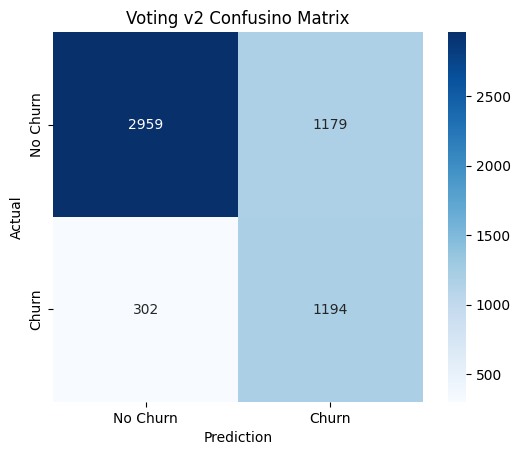

In [96]:
y_probs = cross_val_predict(voting, X_train, y_train, cv=3, method='predict_proba')[:, 1]
y_pred = (y_probs >= voting_decision_threshold)

voting_confusion_matrix_v2 = confusion_matrix(y_train, y_pred)

print(f'Accuracy: {accuracy_score(y_train, y_pred).round(3)}')
print(f'Precision: {precision_score(y_train, y_pred).round(3)}')
print(f'Recall: {recall_score(y_train, y_pred).round(3)}')
print(f'F1: {f1_score(y_train, y_pred).round(3)}')
beautified_confusion_matrix(voting_confusion_matrix_v2, "Voting v2")

### 8.7.2. Evaluate a Model with the Test Set <a id = 8.7.2></a>
[Return to Table of Contents](#0)

Accuracy: 0.749
Precision: 0.516
Recall: 0.845
F1: 0.64


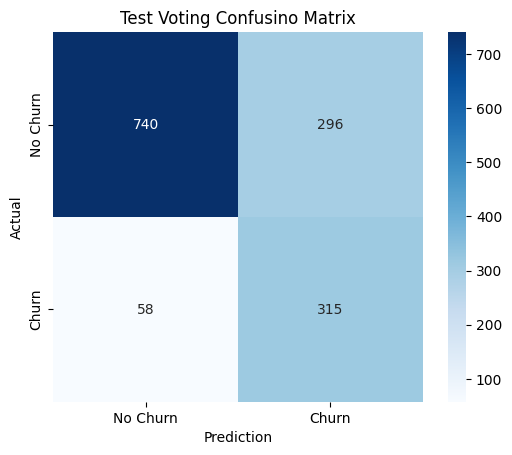

In [97]:
voting.fit(X_train, y_train)
y_probs = voting.predict_proba(X_test)[:,1]
y_pred = (y_probs >= voting_decision_threshold)

voting_test_confusion_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)}')
print(f'Precision: {precision_score(y_test, y_pred).round(3)}')
print(f'Recall: {recall_score(y_test, y_pred).round(3)}')
print(f'F1: {f1_score(y_test, y_pred).round(3)}')
beautified_confusion_matrix(voting_test_confusion_matrix, "Test Voting")

### 8.7.3. ROC and AUC <a id = 8.7.7></a>
[Return to Table of Contents](#0)

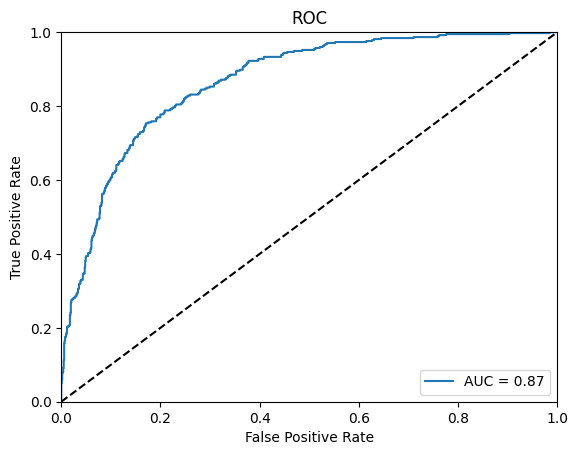

In [98]:
vt_fpr, vt_tpr, vt_thresholds = roc_curve(y_test, y_probs)
vt_roc_auc = auc(vt_fpr, vt_tpr)

plt.title('ROC')
plt.plot(vt_fpr, vt_tpr, label = 'AUC = %0.2f' % vt_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'k--', label = 'Random Guess')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# 9. Choose a Model <a id = 9></a>
[Return to Table of Contents](#0)

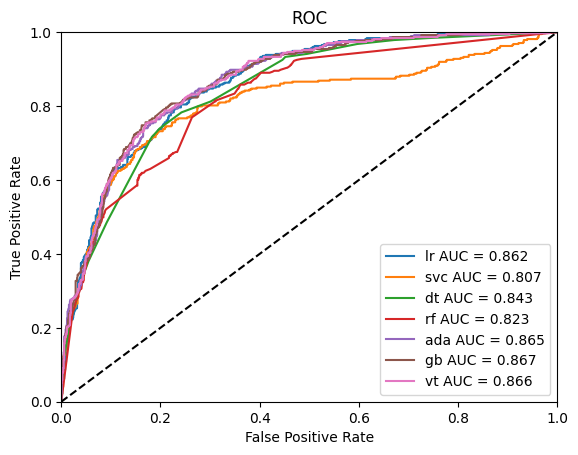

In [99]:
plt.title('ROC')
plt.plot(lr_fpr, lr_tpr, label = 'lr AUC = %0.3f' % lr_roc_auc)
plt.plot(svc_fpr, svc_tpr, label = 'svc AUC = %0.3f' % svc_roc_auc)
plt.plot(dt_fpr, dt_tpr, label = 'dt AUC = %0.3f' % dt_roc_auc)
plt.plot(rf_fpr, rf_tpr, label = 'rf AUC = %0.3f' % rf_roc_auc)
plt.plot(ada_fpr, ada_tpr, label = 'ada AUC = %0.3f' % ada_roc_auc)
plt.plot(gb_fpr, gb_tpr, label = 'gb AUC = %0.3f' % gb_roc_auc)
plt.plot(vt_fpr, vt_tpr, label = 'vt AUC = %0.3f' % vt_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'k--', label = 'Random Guess')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

The Voting Classifier class didn't improve the model much, so I would choose either __AdaBoost__ or __Gradient Boosting__ method. Since Gradient Boosting has the largest AUC on the test set, let's look at its confusion matrix once again.

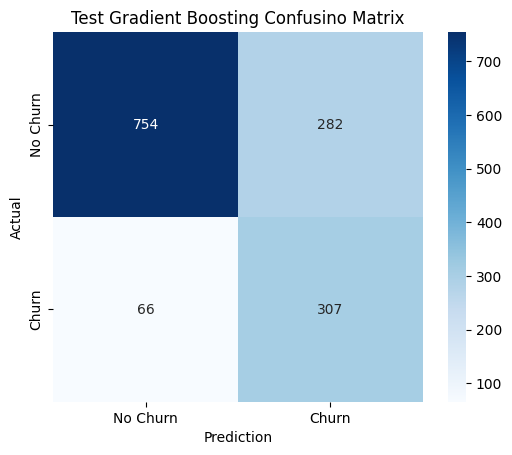

In [100]:
beautified_confusion_matrix(gb_test_confusion_matrix, "Test Gradient Boosting")

The model did a good job minimizing false negatives achieving about 82% recall (307 / 372). However, when the model predicts that an instance is positive, it makes a mistake almost 50% of the time. I was hoping that the best model would achieve a slightly higher precision score, but AdaBoost or Gradient Boosting models were the best among the algorithms we have tried in this kernel.

# 10. Conclusion <a id = 10></a>
[Return to Table of Contents](#0)

Thank you very much for reading my kernel. If you liked this kernel, please upvote, and any feedback/comment is much appreciated!

Best, <br>
Seiji